2025-02-18 10:21:35.465777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 10:21:35.771595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 10:21:35.904952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 10:21:35.936982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 10:21:36.149199: I tensorflow/core/platform/cpu_feature_guar

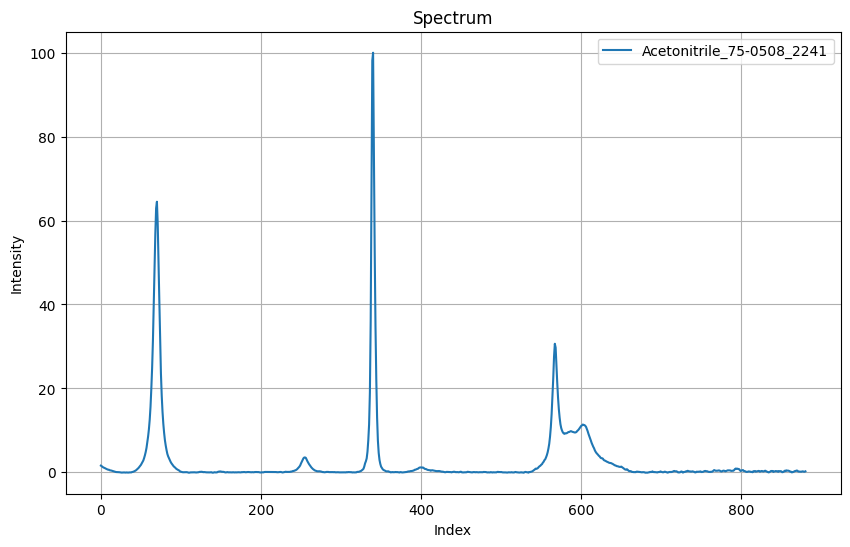

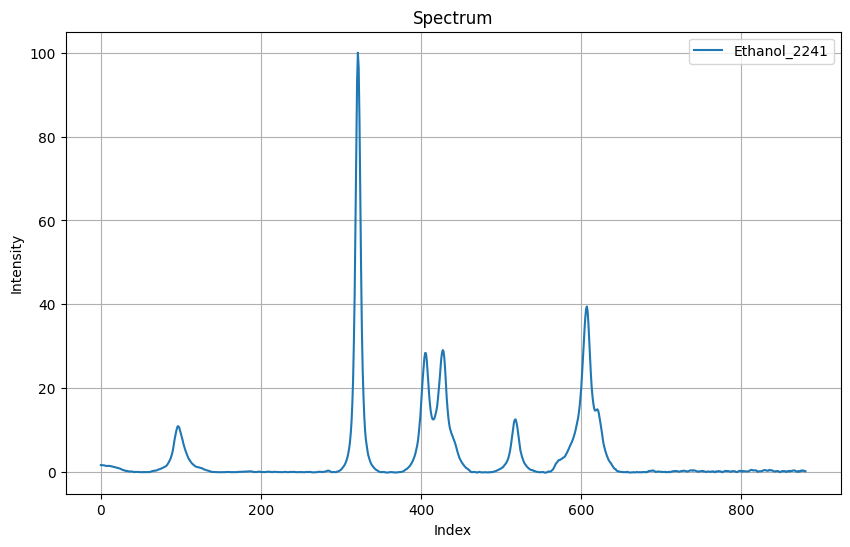

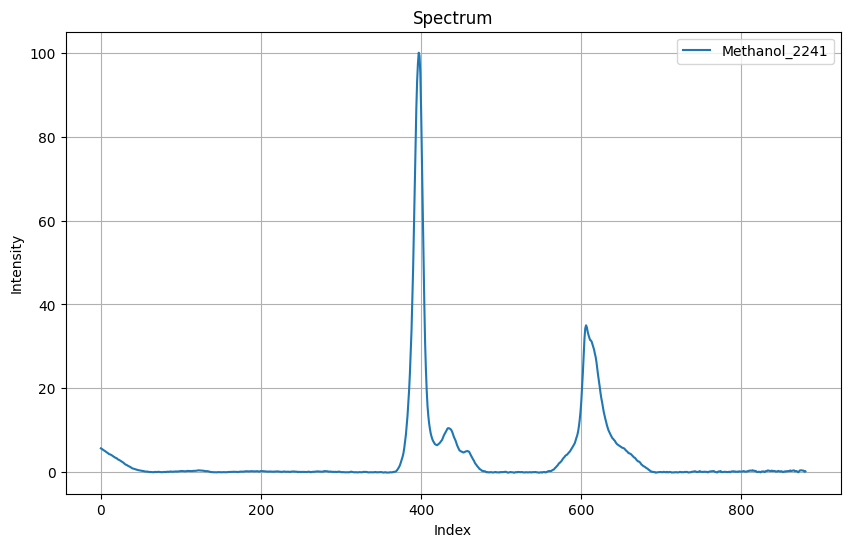

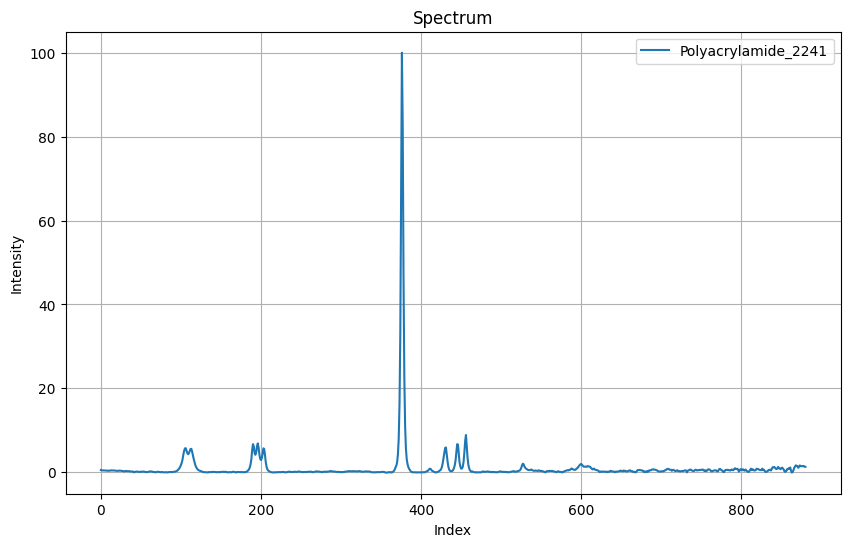

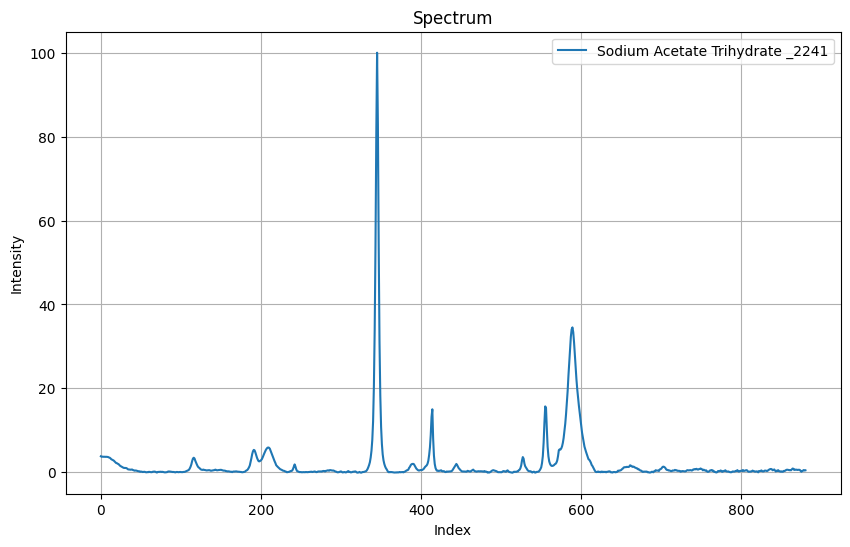

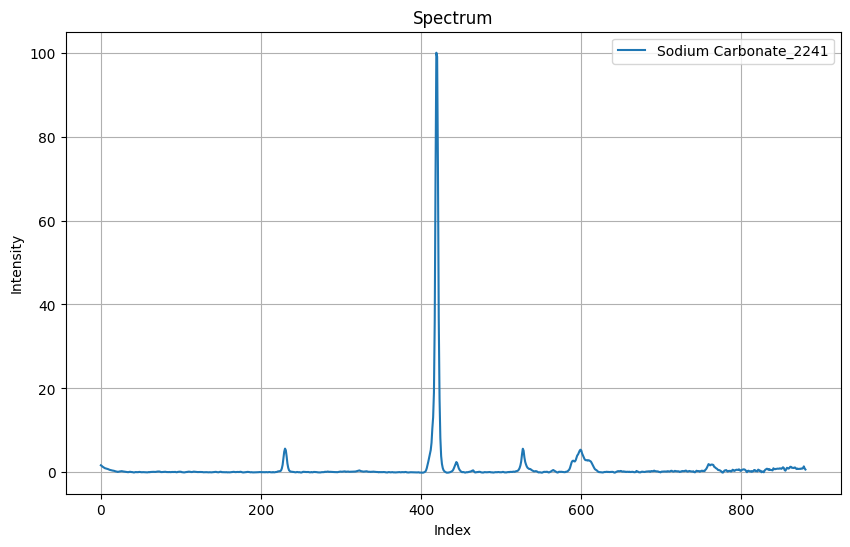

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import enet_path
from scipy.sparse import spdiags,eye,csc_matrix, diags
from scipy.sparse.linalg import spsolve
import csv

def WhittakerSmooth(x, lamb, w):
        m = w.shape[0]
        W = spdiags(w, 0, m, m)
        D = eye(m - 1, m, 1) - eye(m - 1, m)
        return spsolve((W + lamb * D.transpose() * D), w * x)


def airPLS(x, lamb=10, itermax=10):
        m = x.shape[0]
        w = np.ones(m)
        for i in range(itermax):
            z = WhittakerSmooth(x, lamb, w)
            d = x - z
            if sum(abs(d[d < 0])) < 0.001 * sum(abs(x)):
                break;
            w[d < 0] = np.exp(i * d[d < 0] / sum(d[d < 0]))
            w[d >= 0] = 0
        return z


def airPLS_MAT(X, lamb=10, itermax=10):
        B = X.copy()
        for i in range(X.shape[0]):
            B[i,] = airPLS(X[i,], lamb, itermax)
        return X - B

    
def WhittakerSmooth_MAT(X, lamb=1):
        C = X.copy()
        w = np.ones(X.shape[1])
        for i in range(X.shape[0]):
            C[i,] = WhittakerSmooth(X[i, :], lamb, w)
    
        return C

# Import Data
# Database
datafile0 = u'./data/database_for_Liquid_and_powder_mixture.npy'
spectrum_pure = np.load(datafile0)

# Component information of database
csv_reader = csv.reader(open(u'./data/database_for_Liquid_and_powder_mixture.csv', encoding='utf-8'))
DBcoms = [row for row in csv_reader]


spectrum_pure = WhittakerSmooth_MAT(spectrum_pure, lamb=1)
spectrum_pure = airPLS_MAT(spectrum_pure, lamb=10, itermax=10)

# Chuẩn hóa
for i in range(spectrum_pure.shape[0]):
         spectrum_pure[i, :] = spectrum_pure[i, :] / np.max(spectrum_pure[i, :]) * 100

for i, idx in enumerate(DBcoms):
        plt.figure(figsize=(10, 6))
        plt.plot(spectrum_pure[i, :], label=idx[0])
        plt.xlabel('Index')
        plt.ylabel('Intensity')
        plt.title(f'Spectrum')
        plt.legend()
        plt.grid(True)
        plt.show()

In [1]:
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

# Khởi tạo một số hàm khử nhiễu dao động
def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z


# Sinh dữ liệu

In [ ]:
# Assuming spectrum_pure is loaded from a file
spectrum_pure = np.load(datafile0)[1:3, :880]  # Use only the second and third spectra (indices 1 and 2) and 880 data points

def make_data_denoise(spectrum_pure, num_samples=15000, channels=2, length=880, width=1):
    # Scale the spectra
    for i in range(spectrum_pure.shape[0]):
        spectrum_pure[i, :] = spectrum_pure[i, :] * 10

    # Initialize the dataset with only one component since we're not mixing spectra
    dataset = np.zeros((num_samples, 1, channels, length, width))
    labels = []

    for i in range(num_samples):
        # Choose a random pure spectrum between spectrum 1 and 2
        pure_index = np.random.choice(2, 1, replace=False)  # Only choose between index 0 and 1 in the subset
        label = np.zeros(2)  
        label[pure_index] = 1
        labels.append(label)

        # Get the pure spectrum and add noise
        pure_spectrum = spectrum_pure[pure_index[0]]
        noisy_spectrum = pure_spectrum + np.random.normal(0, 1, size=len(pure_spectrum))

        # Normalize both spectra
        pure_spectrum = pure_spectrum / np.max(pure_spectrum) 
        noisy_spectrum = noisy_spectrum / np.max(noisy_spectrum) 

        # Store the spectra in the dataset
        dataset[i, 0, 0, :, :] = pure_spectrum.reshape((880, 1))
        dataset[i, 0, 1, :, :] = noisy_spectrum.reshape((880, 1))

    labels = np.array(labels)
    
    # Check the shape of dataset and labels
    print("Dataset shape:", dataset.shape)
    print("Labels shape:", labels.shape)

    # Save dataset, labels
    np.save('./data/dataset_noise_pure_182.npy', dataset)
    np.save('./data/labels_noise_pure_182.npy', labels)

# Run the function
make_data_denoise(spectrum_pure)


In [2]:
def poly_baseline(x):
    # Tạo các giá trị x từ 0 đến 1024
    p = np.random.uniform(1, 3)  # Đặt bậc của đa thức trong khoảng từ 1 đến 3
    intensity = np.random.uniform(0.5, 1)  # Đặt độ lớn của biên độ trong khoảng từ 0.5 đến 1
    b = np.random.uniform(-0.5, 0.5)  # Đặt độ lệch trong khoảng từ -0.5 đến 0.5

    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x):
    mean = np.random.uniform(0, 880)  # Đặt trung bình trong khoảng từ 0 đến 800
    sd = np.random.uniform(100, 600)  # Đặt độ lệch chuẩn trong khoảng từ 100 đến 600
    intensity = np.random.uniform(0.5, 1)  # Đặt độ lớn của biên độ trong khoảng từ 0.5 đến 1
    b = np.random.uniform(-0.5, 0.5)  # Đặt độ lệch trong khoảng từ -0.5 đến 0.5

    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def trigonometric_baseline(x):
    p = np.random.uniform(10, 8*np.pi)
    intensity = np.random.uniform(0, 1)
    y=np.sin(p*x/len(x))
    return intensity*y/max(y)+intensity

def generate_spectrum(input, num_baselines=2):
    x_range = np.linspace(0,input.shape[0], input.shape[0])
    baseline_labels = np.random.randint(0, 2, size=num_baselines)  # Generate random baseline labels

    baselines = [poly_baseline, gaussian_baseline]

    noisy_spectrum = input / np.max(input)
    spectrum = input / np.max(input)
    baselines_applied = []
    for i in range(num_baselines):
        if baseline_labels[i] == 1:
            baseline_func = baselines[i]
            baseline = baseline_func(x_range)
            baseline = baseline.reshape((-1,1))
            noisy_spectrum += baseline
    
    baselines_applied.append(noisy_spectrum - spectrum)
    baselines_applied = np.array(baselines_applied)
    return noisy_spectrum, baseline_labels, baselines_applied

In [3]:
import pandas as pd
import numpy as np
# Tạo dữ liệu cho 20,000 mẫu
num_samples = 10000
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_noise_pure_182.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
for inputs in Inputs:
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, : , :], num_baselines=2)
    all_baseline_labels.append(baseline_labels)  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_noisy_spectra.append(noisy_spectrum.flatten())  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_baseline_applied.append(baseline_applied.flatten())

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)

# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_noise_01104.csv', index=False)
print("ok")

ok


In [6]:
import pandas as pd

# Tạo dữ liệu cho 20,000 mẫu
num_samples = 10000
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_noise_pure_182.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
for inputs in Inputs:
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, : , :], num_baselines=2)
    all_baseline_labels.append(baseline_labels)  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_noisy_spectra.append(noisy_spectrum.flatten())  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_baseline_applied.append(baseline_applied.flatten())

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

print(all_baseline_applied.shape)
# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)
# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_test_01104.csv', index=False)
print('ok')

(15000, 880)
ok


In [4]:
import pandas as pd
import tensorflow as tf
# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_noise_01104.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")
# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

# Hiển thị kích thước của x_train và y_train+
print("Kích thước x_train:", x_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước baseline_train:", baseline_train.shape)

Đọc dữ liệu
Kích thước x_train: (15000, 880)
Kích thước y_train: (15000, 2)
Kích thước baseline_train: (15000, 880)


In [3]:
def ConvClassifica():
    input = tf.keras.layers.Input((880,))
    input_reshaped = tf.keras.layers.Reshape((880, 1))(input)  # Thêm lớp Reshape để tạo ra kích thước (None, 1024, 1)
    conv1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, activation='relu')(input_reshaped)
    pool1 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2)(conv1)
    flatten = tf.keras.layers.Flatten()(pool1)
    fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    fc2 = tf.keras.layers.Dense(2, activation='sigmoid')(fc1)  # Số lượng đầu ra là 4
    model = tf.keras.Model(inputs=input, outputs=fc2)
    return model

# Tạo một thể hiện của mạng ConvClassifica
model = ConvClassifica()

# Kiểm tra kiến trúc của mô hình TensorFlow

model.summary()

#load trọng số
model.load_weights("./model.weights.h5")

I0000 00:00:1739848903.790382  138488 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739848904.008514  138488 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739848904.008702  138488 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739848904.026686  138488 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739848904.026833  138488 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 880, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 876, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 438, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       700,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,198 (2.67 MB)

 Trainable params: 701,198 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import tensorflow as tf
spectra_num = len(x_train)
train_split = round(0.9 * spectra_num)
val_split = round(0.1 * spectra_num)

x_trainn = x_train[:train_split]
x_test = x_train[train_split:train_split+val_split]

y_trainn = y_train[:train_split]
y_test = y_train[train_split:train_split+val_split]
# Tạo Dataset cho dữ liệu huấn luyện
train_dataset = tf.data.Dataset.from_tensor_slices((x_trainn, y_trainn)).batch(64)

# Tạo Dataset cho dữ liệu kiểm tra
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Train 
# Tạo mô hình
model = ConvClassifica()
import tensorflow.keras.backend as K

def Custom_Hamming_Loss(y_true, y_pred):
  return K.mean(y_true*(1-y_pred)+(1-y_true)*y_pred)

def Custom_Hamming_Loss1(y_true, y_pred):
  tmp = K.abs(y_true-y_pred)
  return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))

# Biên dịch mô hình với optimizer và Hamming loss function
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy',Custom_Hamming_Loss, Custom_Hamming_Loss1])

# Huấn luyện mô hình
history = model.fit(train_dataset, validation_data=test_dataset, epochs=35)
# model.save_weights('./model.weights.h5')

In [18]:
# Chọn một mẫu dữ liệu từ x_train
sample_index = 55
sample_data = x_train[sample_index]

# Chuẩn bị mẫu dữ liệu này để phù hợp với đầu vào của mô hình
sample_data = tf.expand_dims(sample_data, axis=0)  # Thêm chiều batch

# Sử dụng mô hình để dự đoán đầu ra cho mẫu dữ liệu đã chọn
predicted_output = model.predict(sample_data)
print("Ground True output for sample", y_train[sample_index])
print("Predicted output for sample", sample_index, ":", predicted_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Ground True output for sample tf.Tensor([1. 1.], shape=(2,), dtype=float32)
Predicted output for sample 55 : [[0.9999596 1.       ]]


In [10]:
import numpy as np
from scipy.optimize import curve_fit

def poly_baseline(x, p, intensity, b):
    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x, mean, sd, intensity, b):
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def pg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = (x / len(x)) ** p + b
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y1 / max(y1) * in1 + y2 / max(y2) * in2

def mix_min(sp, baseline ,Previous_Dev):
    # new_baseline = np.minimum(baseline,sp)
    condition1 = (sp > baseline)
    condition1_2 = (sp < baseline + Previous_Dev)
    condition2_2 = (baseline - Previous_Dev < sp)
    # new_baseline = np.where(sp < baseline + Previous_Dev, sp, baseline + Previous_Dev)
    new_baseline = np.where(condition1, np.where(condition1_2, sp, baseline + Previous_Dev), np.where(condition2_2, baseline - Previous_Dev, sp))

    return new_baseline

def iterative_fitting_with_bounds(sp, ite):
    # Initialize the baseline
    fitted_baseline = np.zeros(880)
    #The bounds is in data_generatorf2.R
    x = np.linspace(1, 880, 880)
    tempb = sp
    torch_tempb = tf.expand_dims(tempb, axis=0)
    i = 0
    tem = []
    Previous_Dev = 0
    while i < ite:
        tadvice = model(torch_tempb)
        if i > 0:
            Previous_Dev = Dev
        if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
            p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]), maxfev=100000)
            fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
        elif tadvice[0][0] >= 0.5:
            p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
            fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
        elif tadvice[0][1] >= 0.5:
            p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]),  maxfev=100000)
            fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
        Dev = np.std(tempb-fitted_baseline)
        tempb = mix_min(sp, fitted_baseline, Dev)
        tem.append(tempb)
        # Convert to numpy array
        tempb_np = np.array(tempb)
        # Convert to tensor
        torch_tempb = tempb_np.reshape(1, 880)   
        i += 1
        if i >= 1:
            if np.abs((Dev-Previous_Dev)/Dev) < 0.005:
                break
    tadvice = model(torch_tempb)
    if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
                    p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]),  maxfev=100000)
                    fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
    elif tadvice[0][0] >= 0.5:
                    p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
                    fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
    elif tadvice[0][1] >= 0.5:
                    p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]), maxfev=100000)
                    fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
    tempb_1 = fitted_baseline
    return tempb_1

In [11]:
import numpy as np
from scipy.optimize import curve_fit

def poly_baseline(x, p, intensity, b):
    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x, mean, sd, intensity, b):
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def pg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = (x / len(x)) ** p + b
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y1 / max(y1) * in1 + y2 / max(y2) * in2

def mix_min_no(sp, baseline):
    new_baseline = np.minimum(baseline,sp)    
    return new_baseline


def iterative_fitting_with_bounds_no(sp, ite):
    # Initialize the baseline
    fitted_baseline = np.zeros(880)
    #The bounds is in data_generatorf2.R
    x = np.linspace(1, 880, 880)
    tempb = sp
    torch_tempb = tf.expand_dims(tempb, axis=0)
    i = 0
    tem = []
    while i < ite:
        tadvice = model(torch_tempb)
        if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
            p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]), maxfev=100000)
            fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
        elif tadvice[0][0] >= 0.5:
            p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
            fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
        elif tadvice[0][1] >= 0.5:
            p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]),  maxfev=100000)
            fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
        tempb = mix_min_no(tempb, fitted_baseline)
        tem.append(tempb)
        # Convert to numpy array
        tempb_np = np.array(tempb)
        # Convert to tensor
        torch_tempb = tempb_np.reshape(1, 880)   
        i += 1

    return tempb

In [21]:
!pip install BaselineRemoval

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Đọc dữ liệu


W0000 00:00:1739848228.996977  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.280401  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.312467  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.354698  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.405398  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.420342  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.462035  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.501791  130920 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739848229.521988  130920 gp

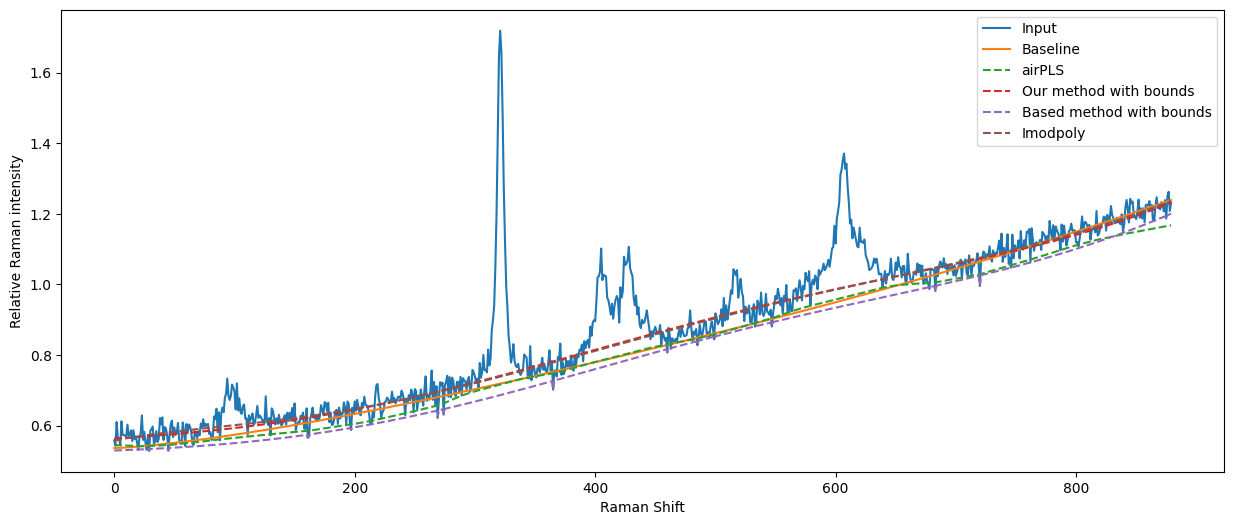

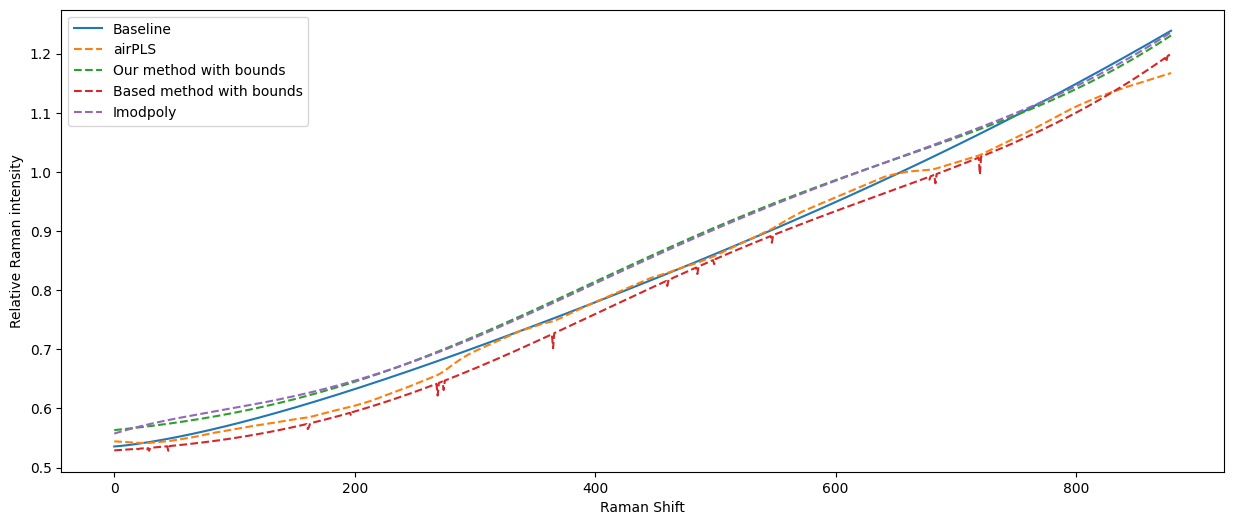

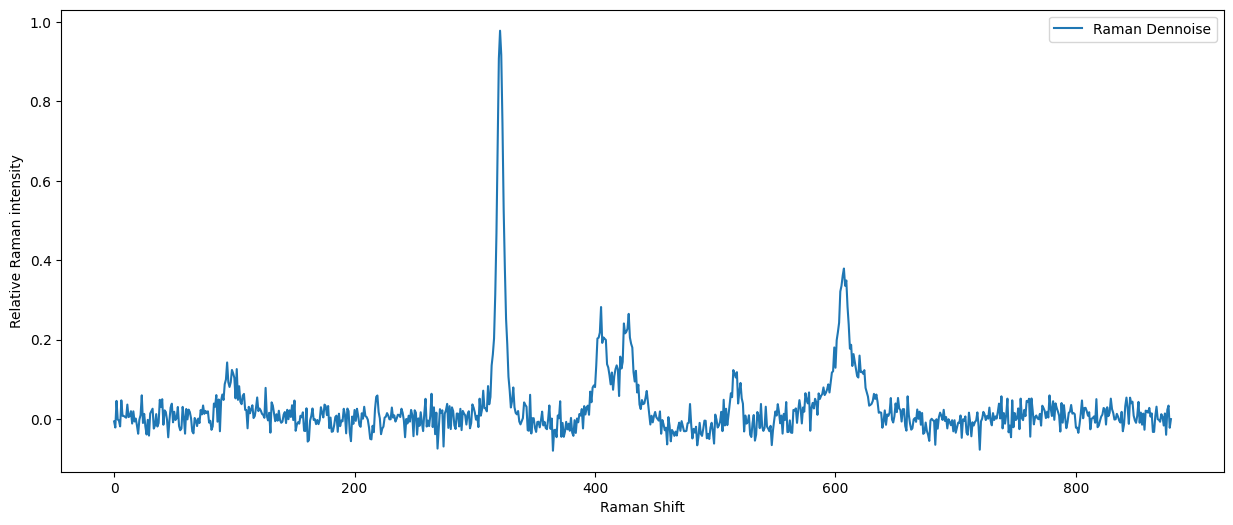

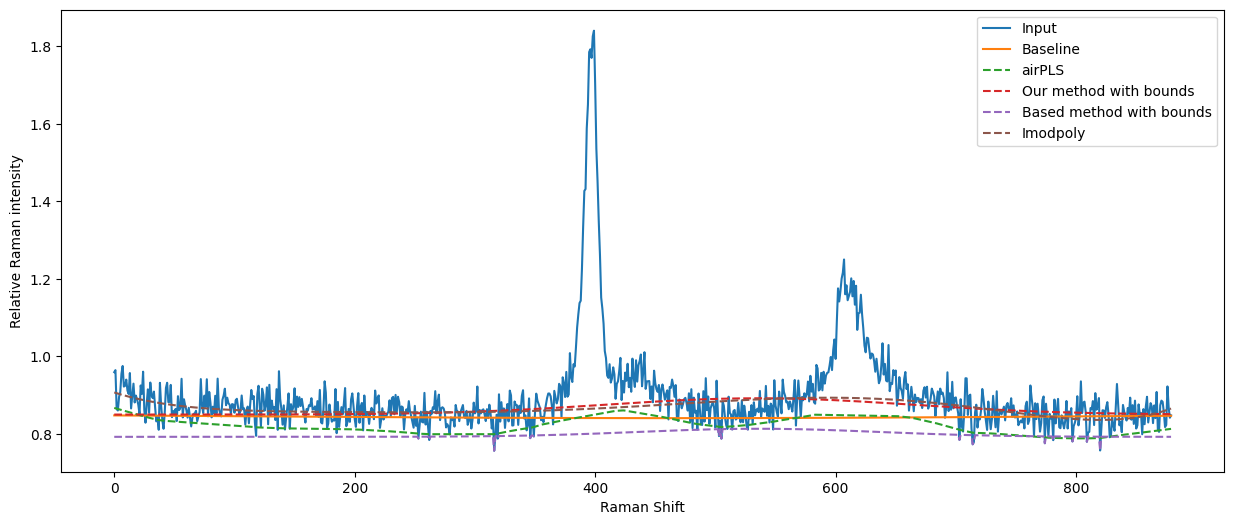

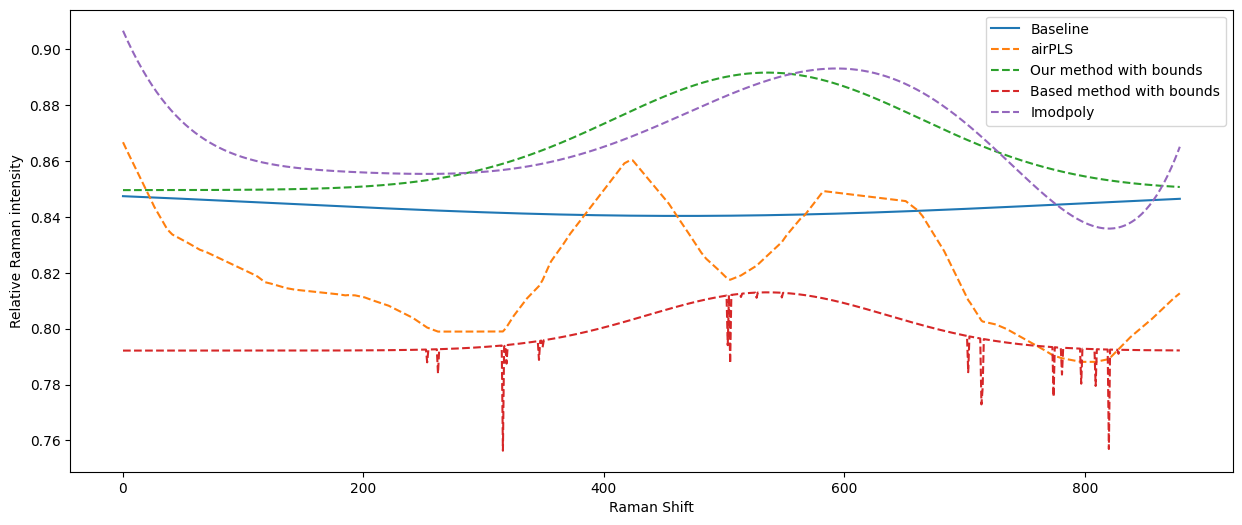

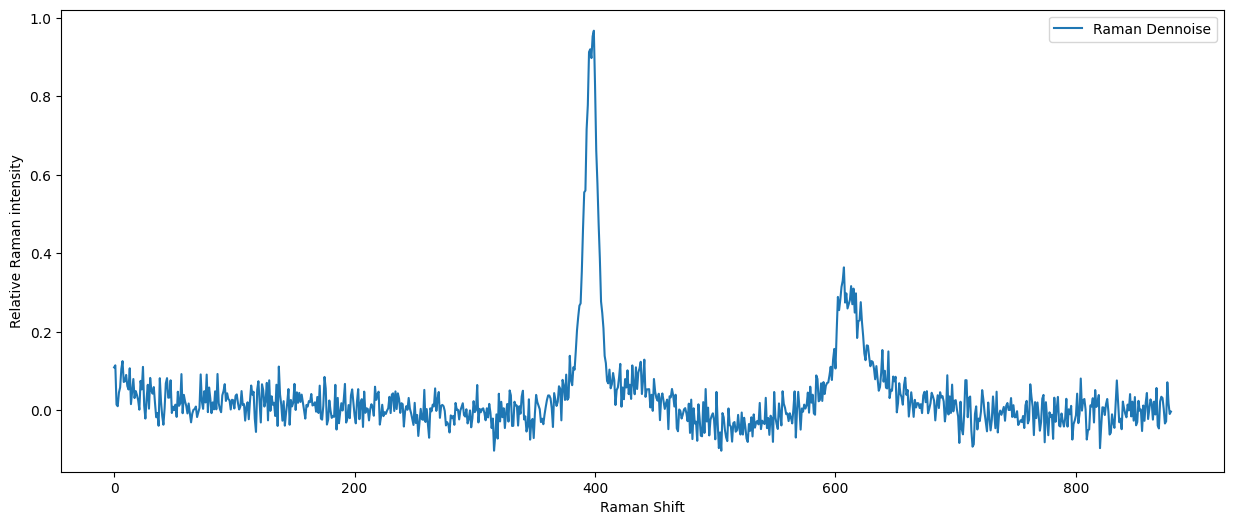

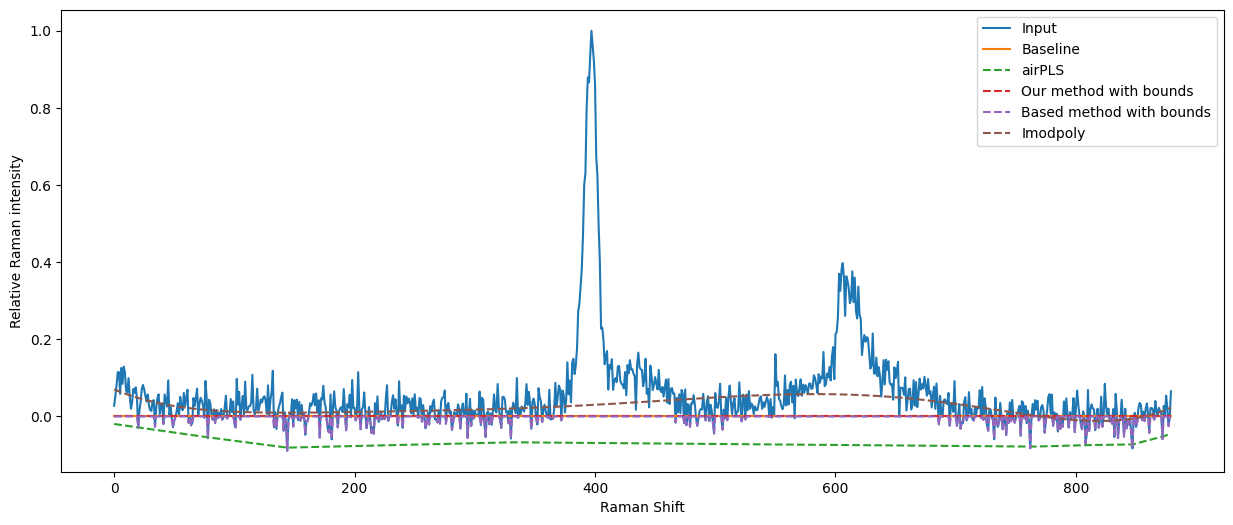

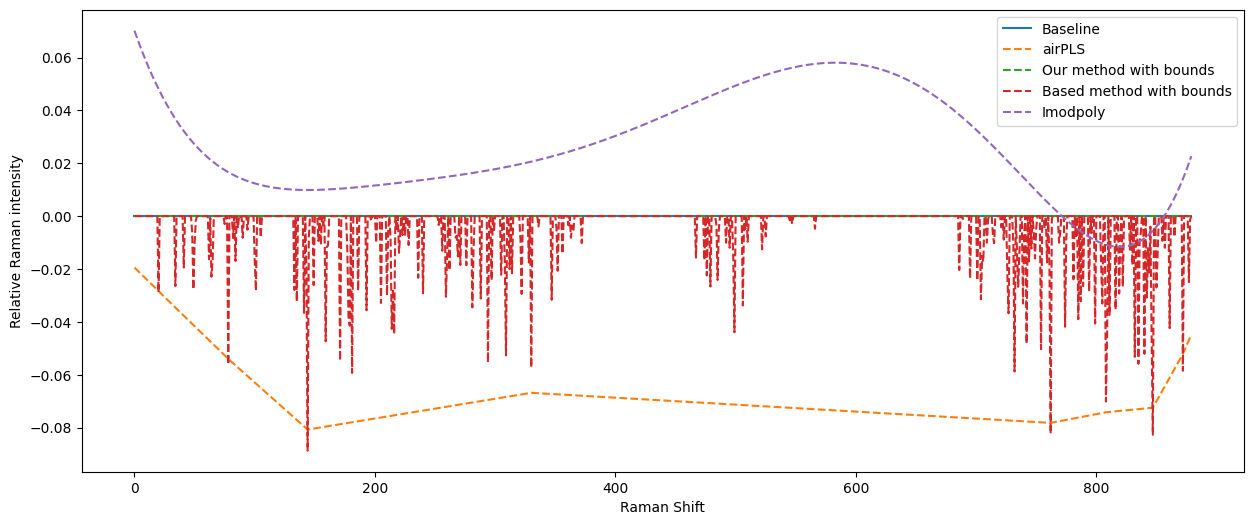

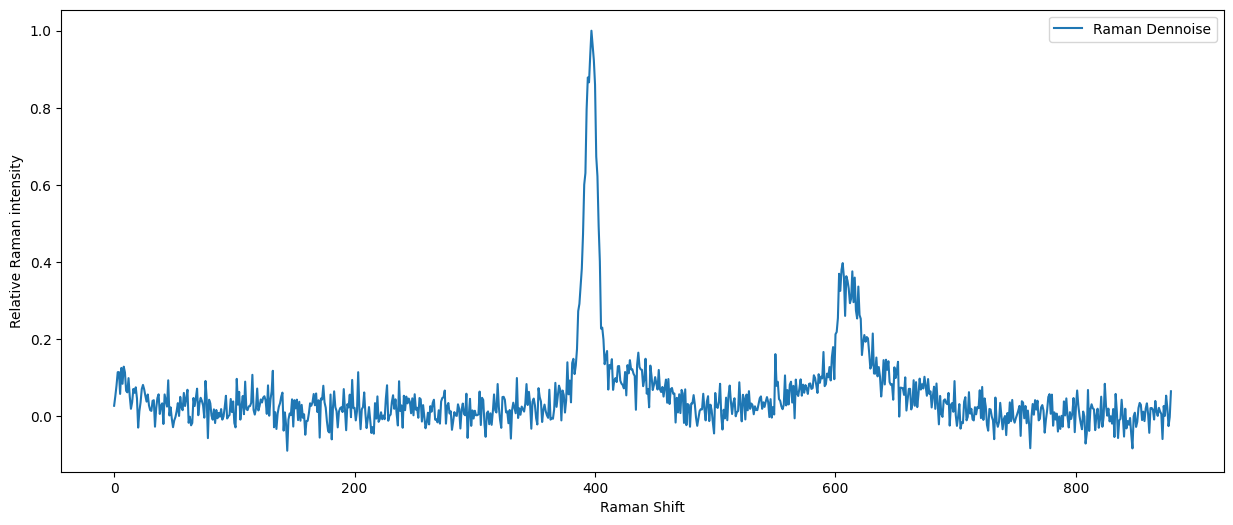

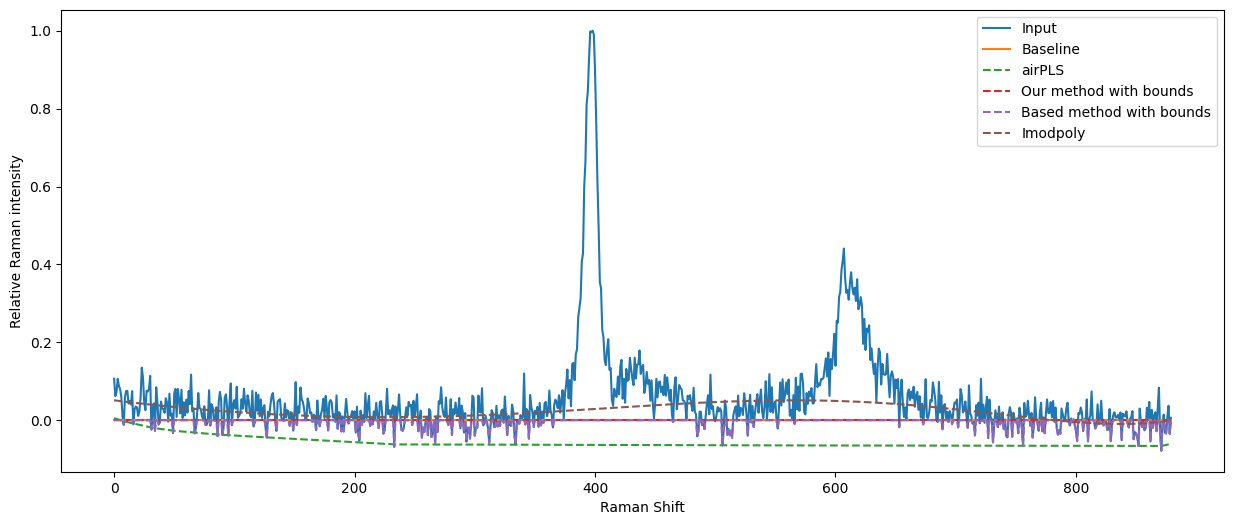

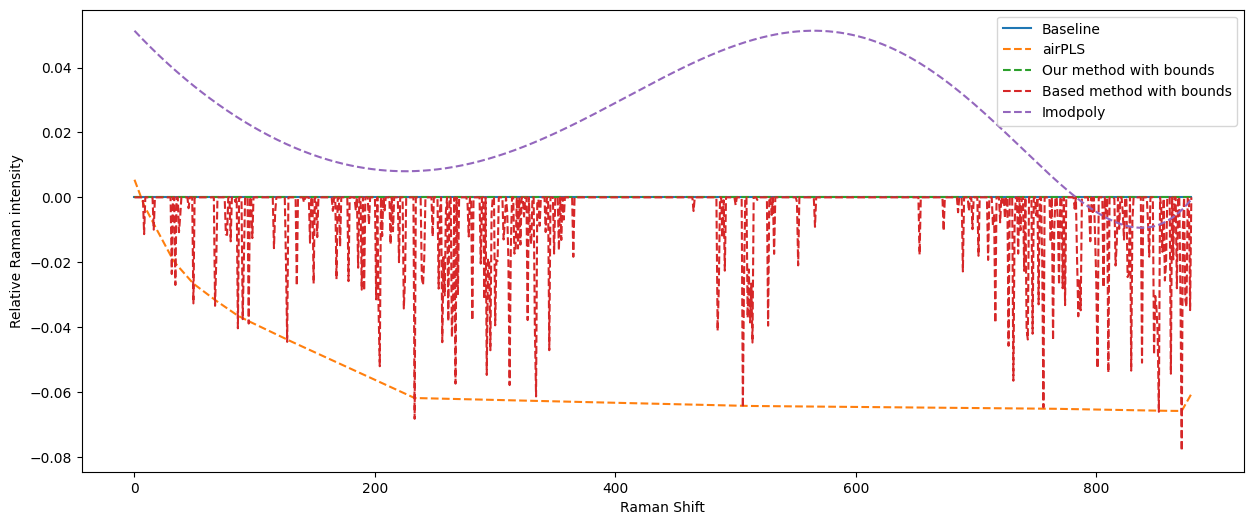

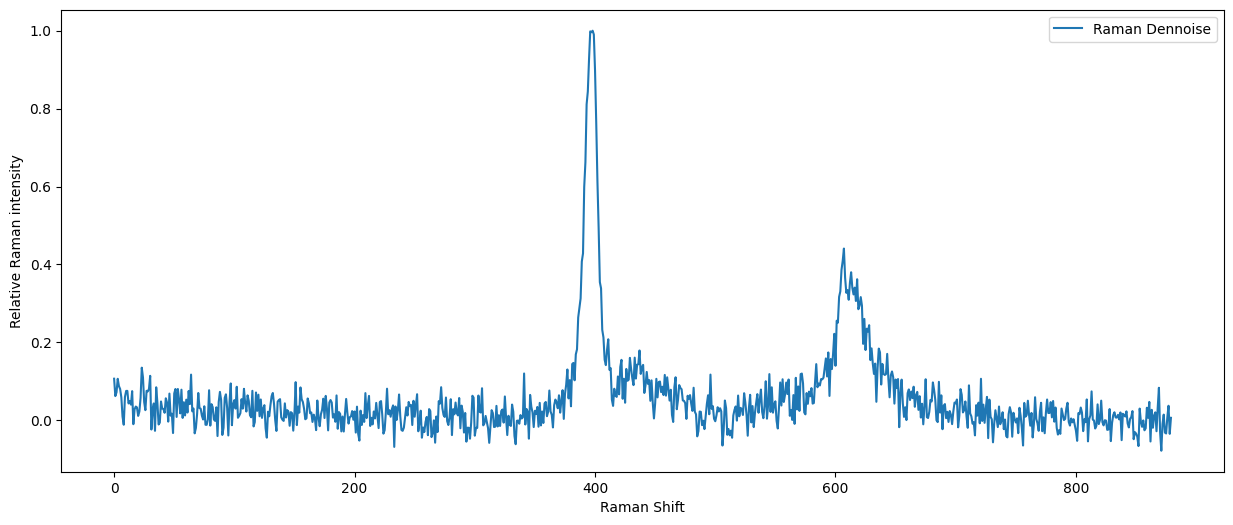

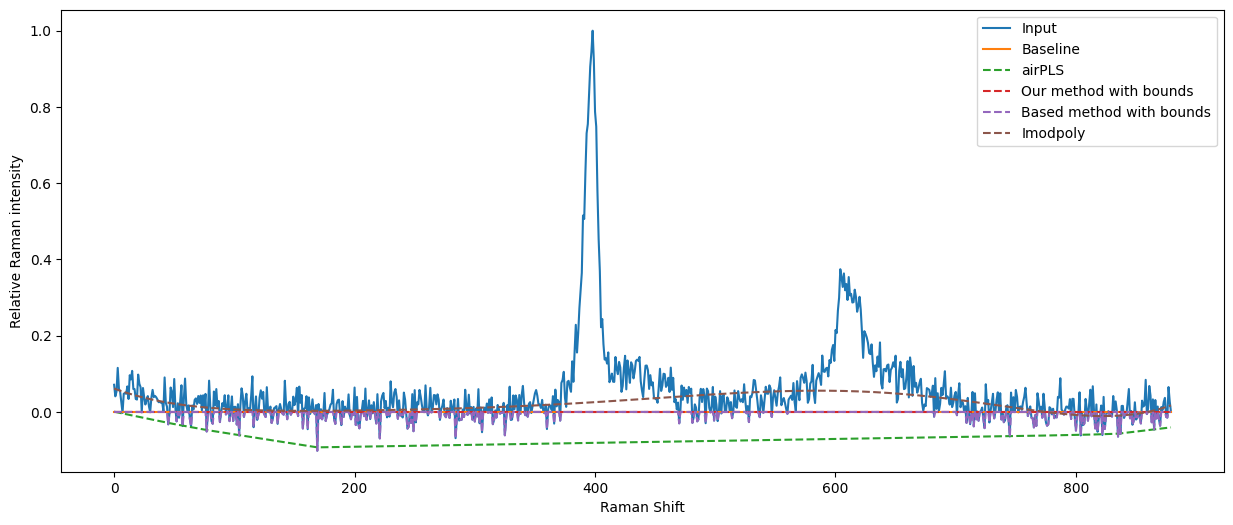

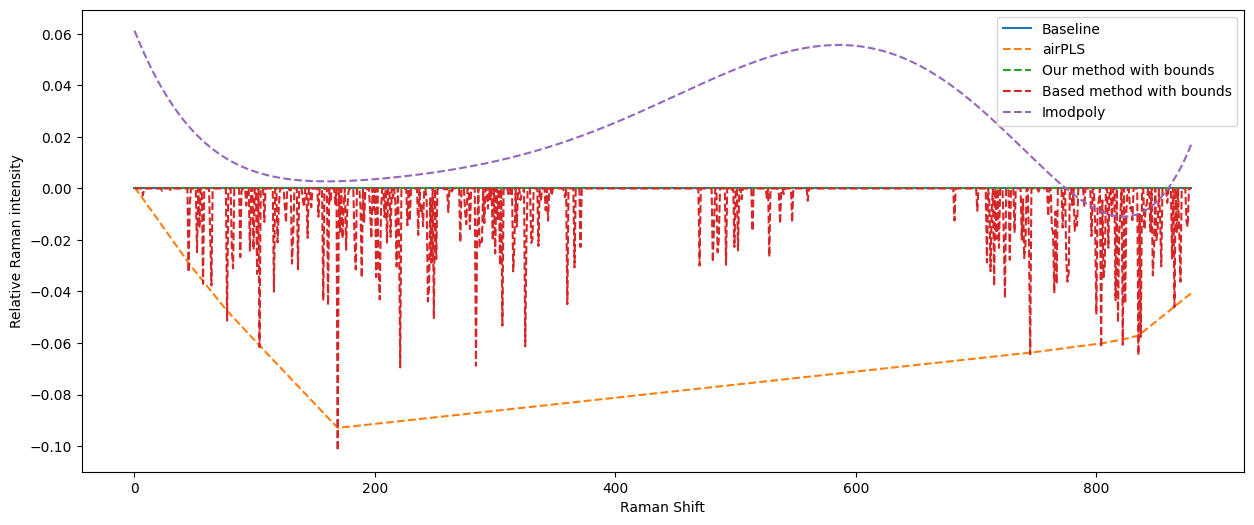

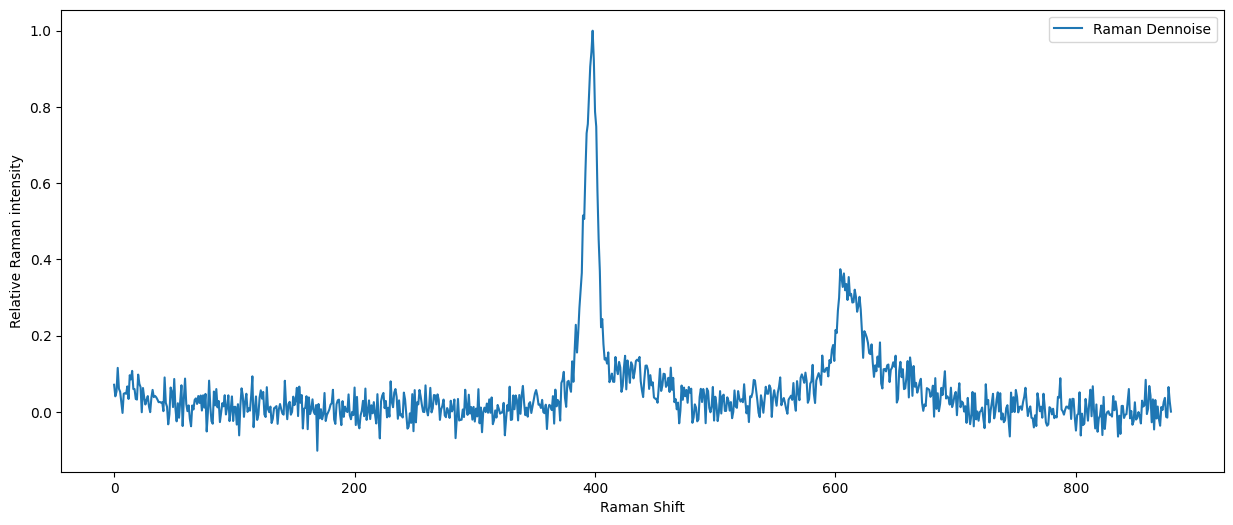

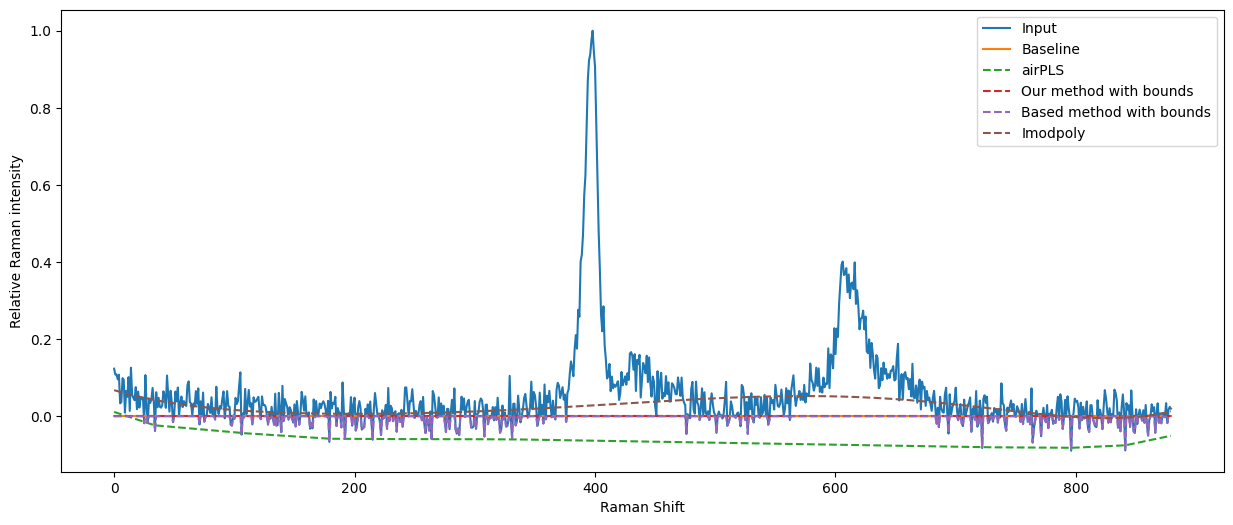

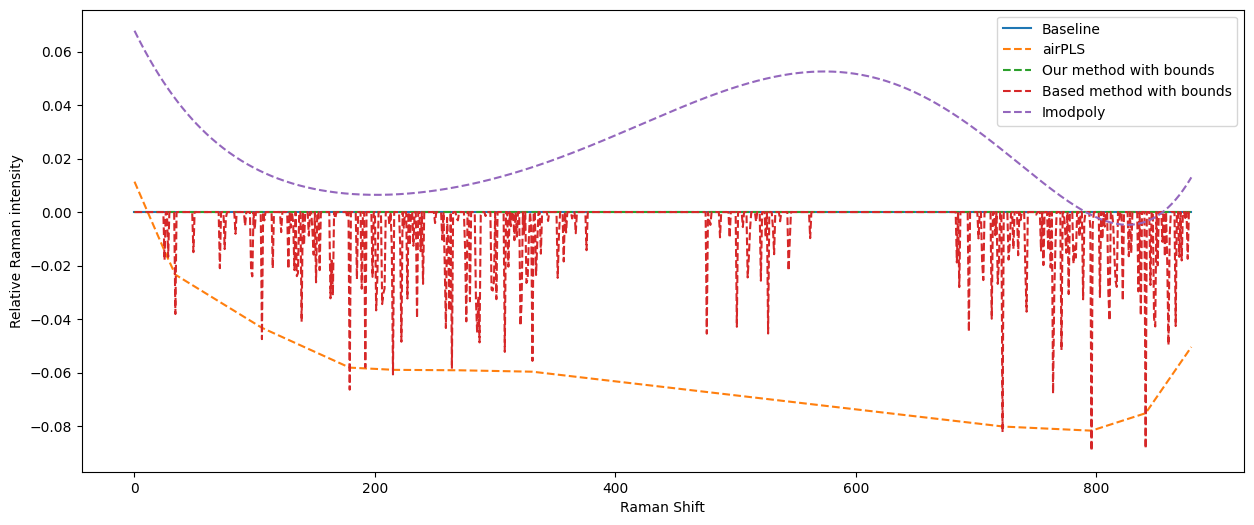

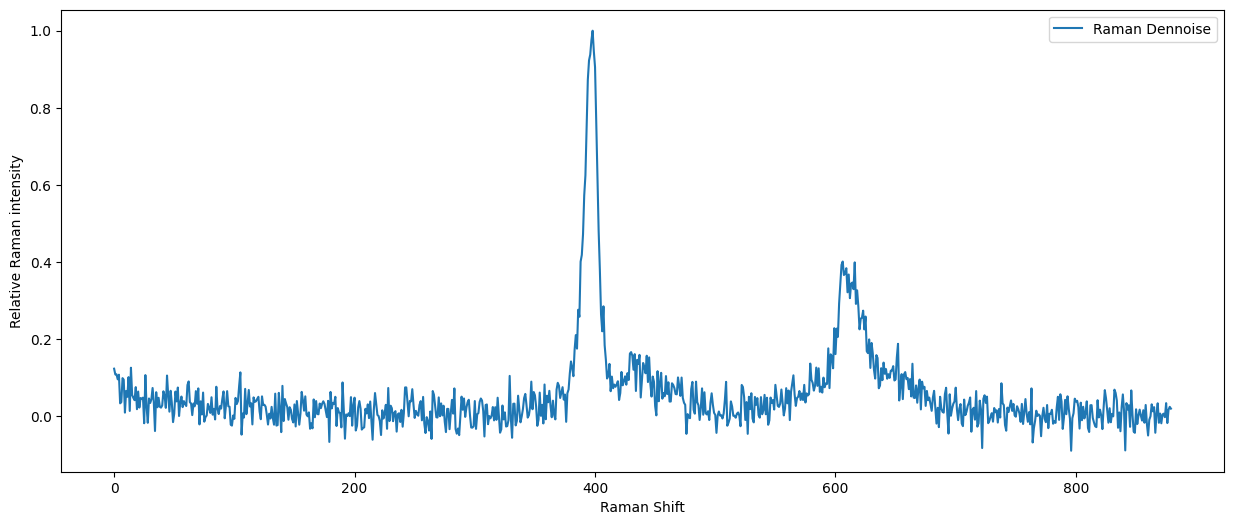

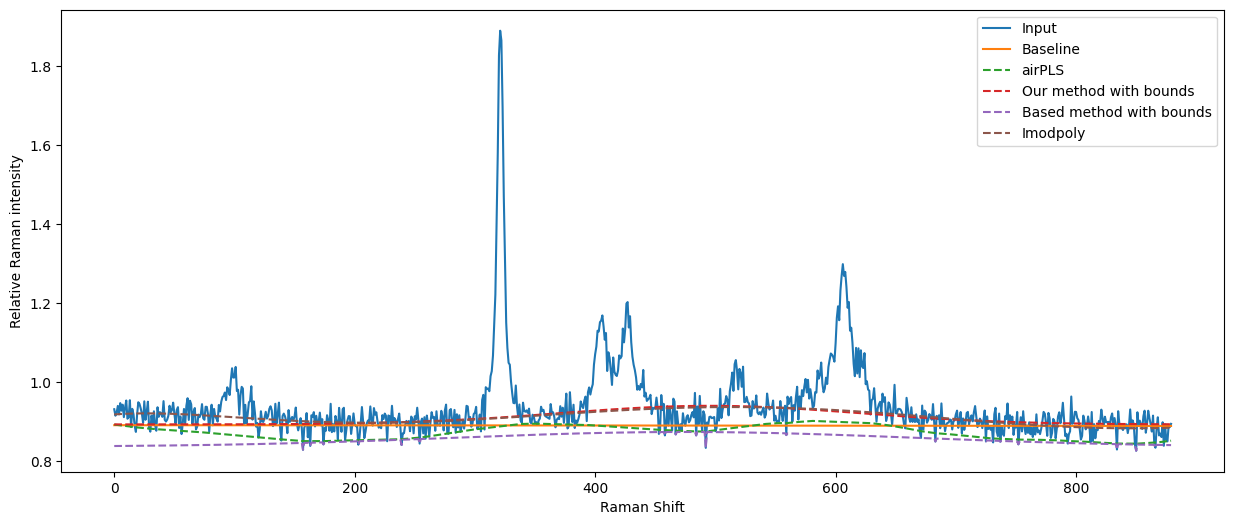

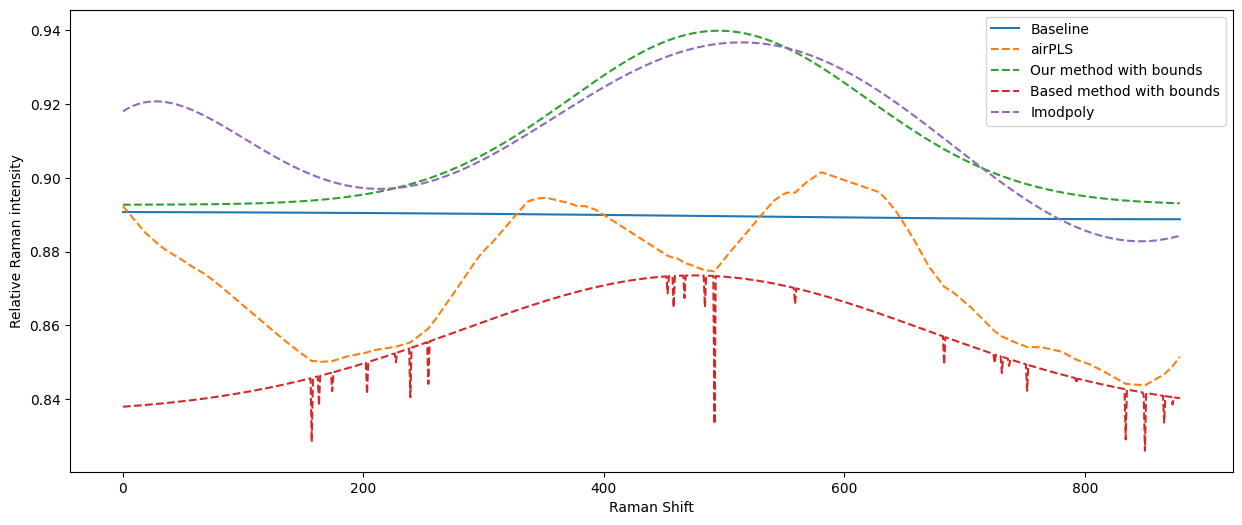

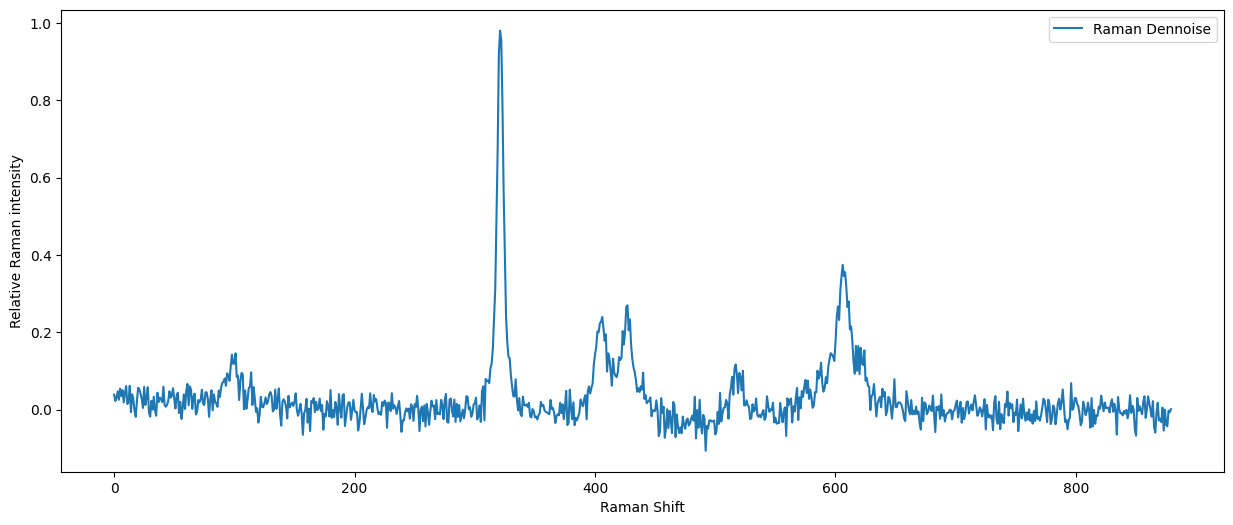

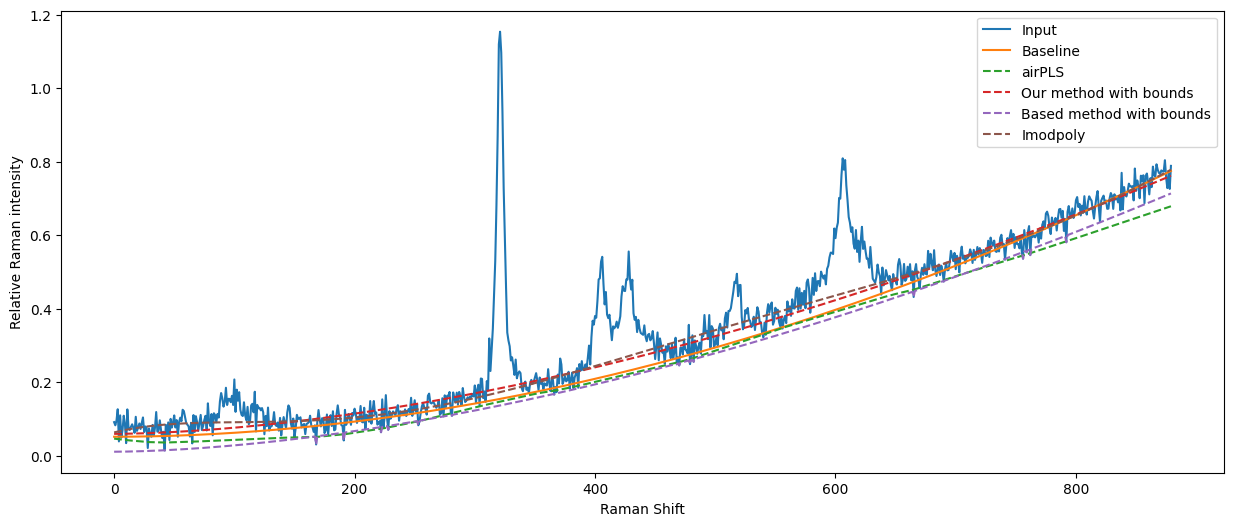

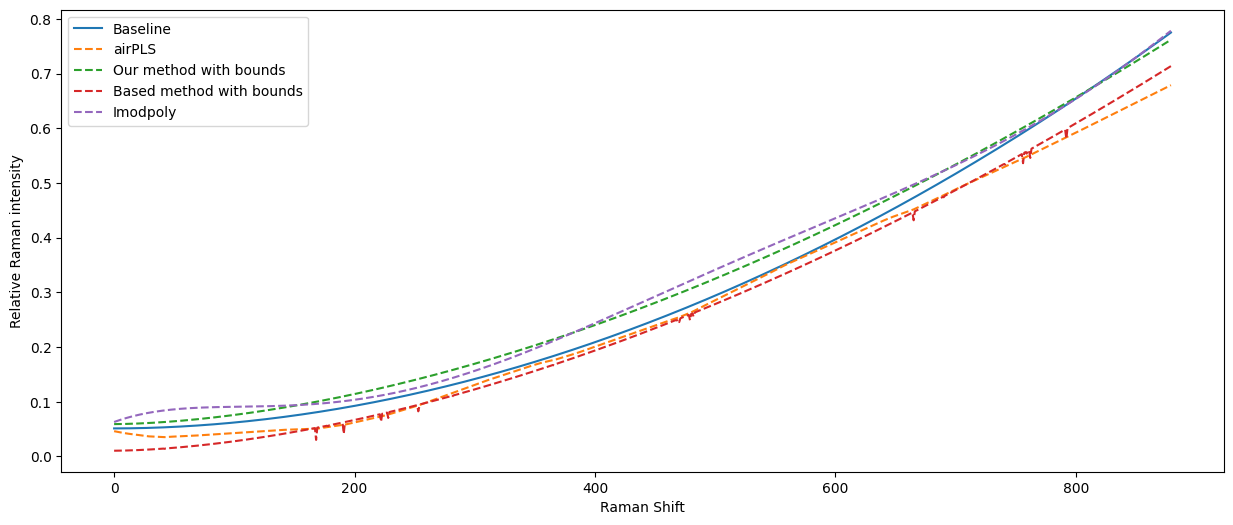

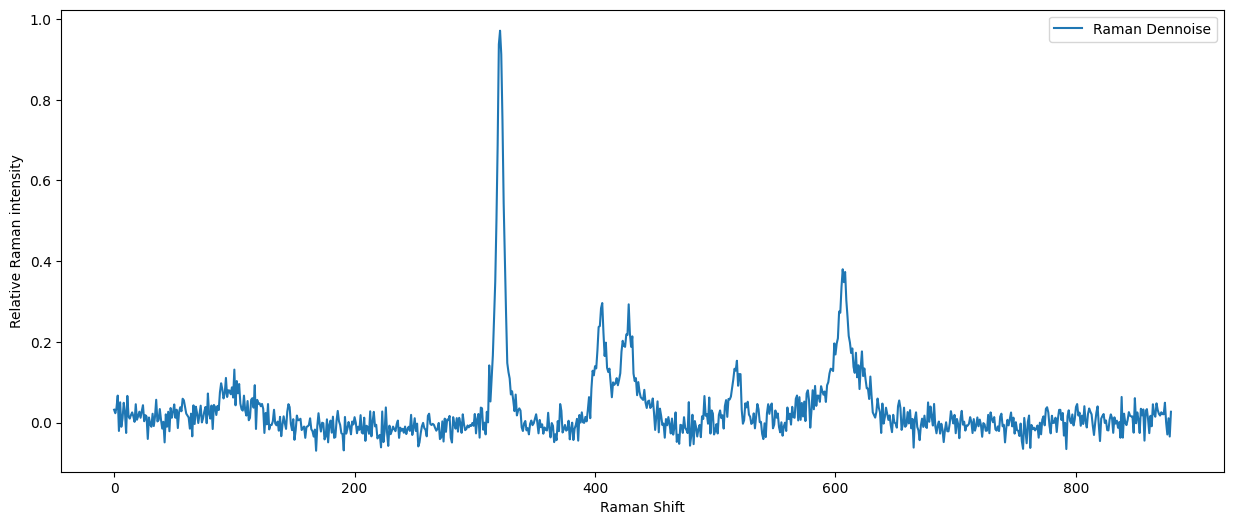

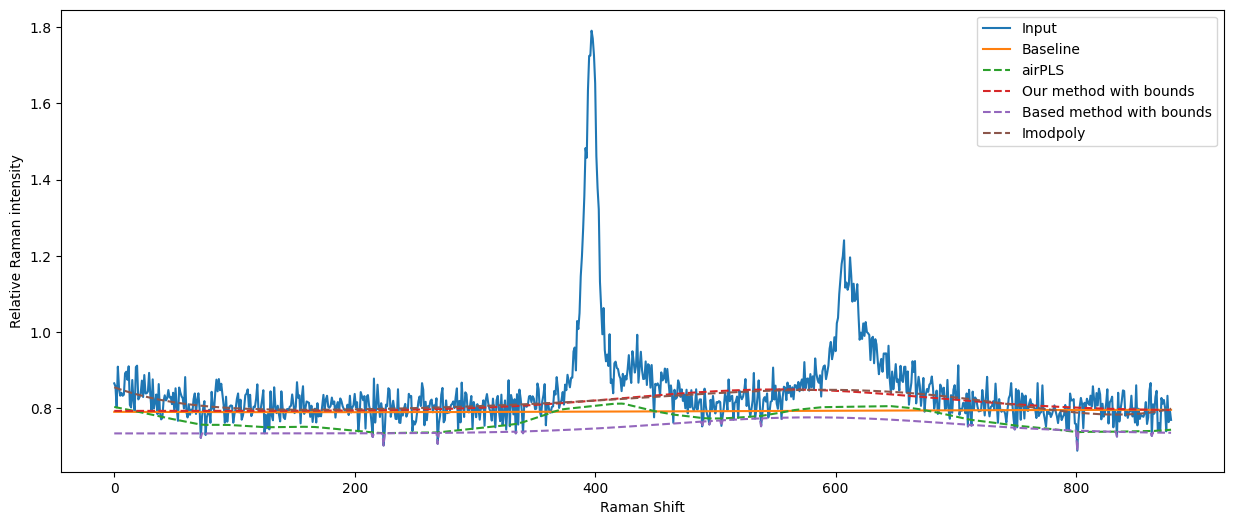

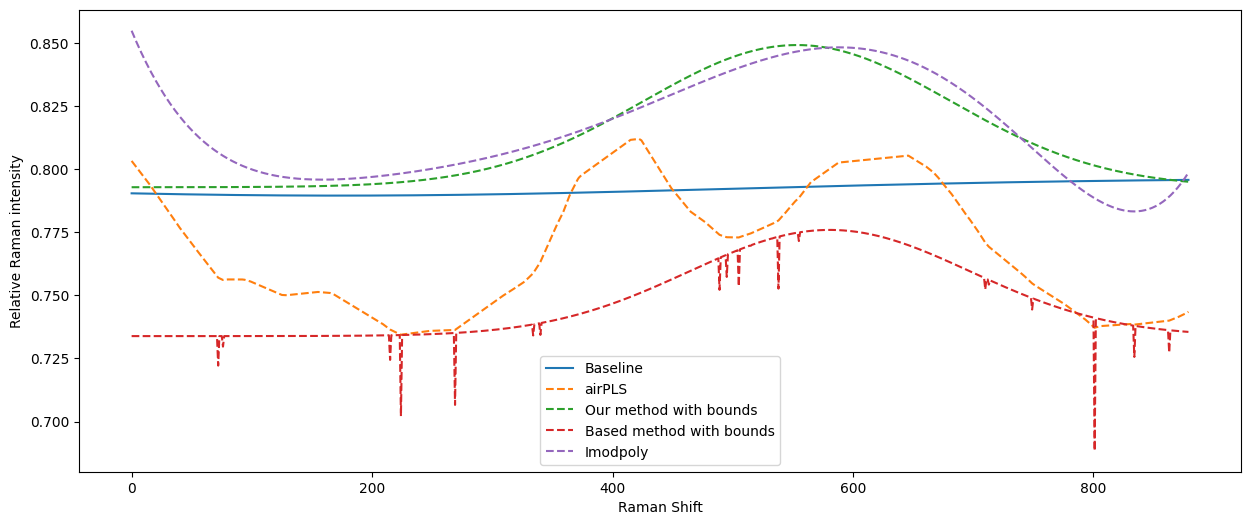

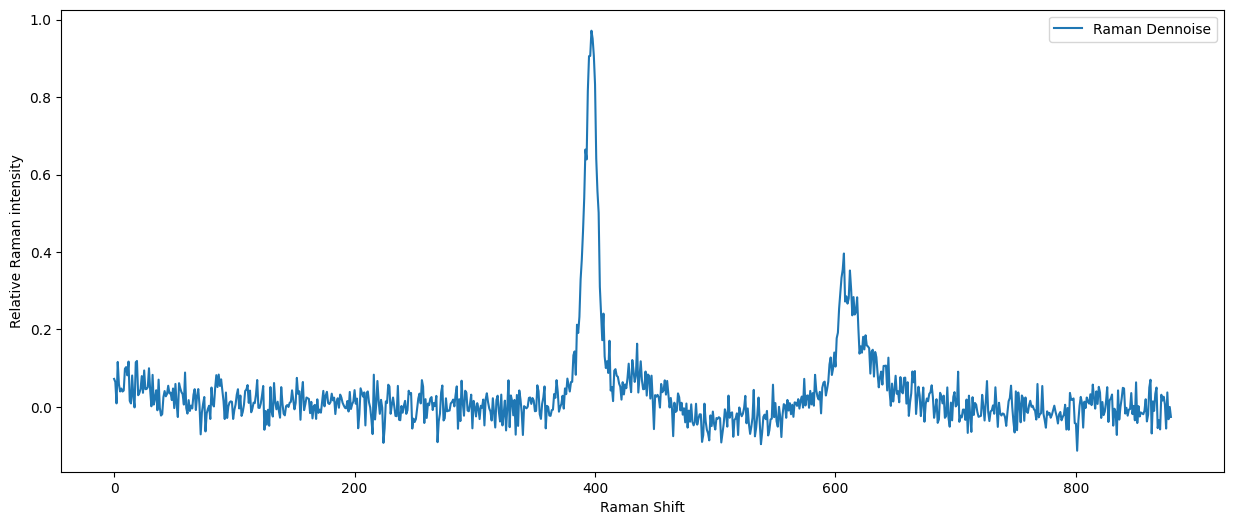

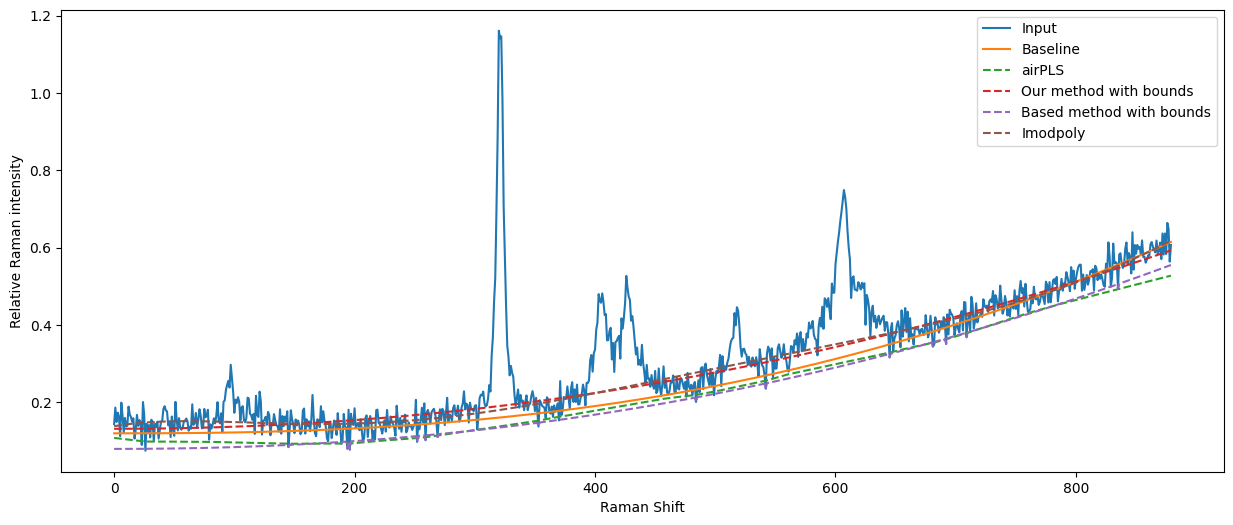

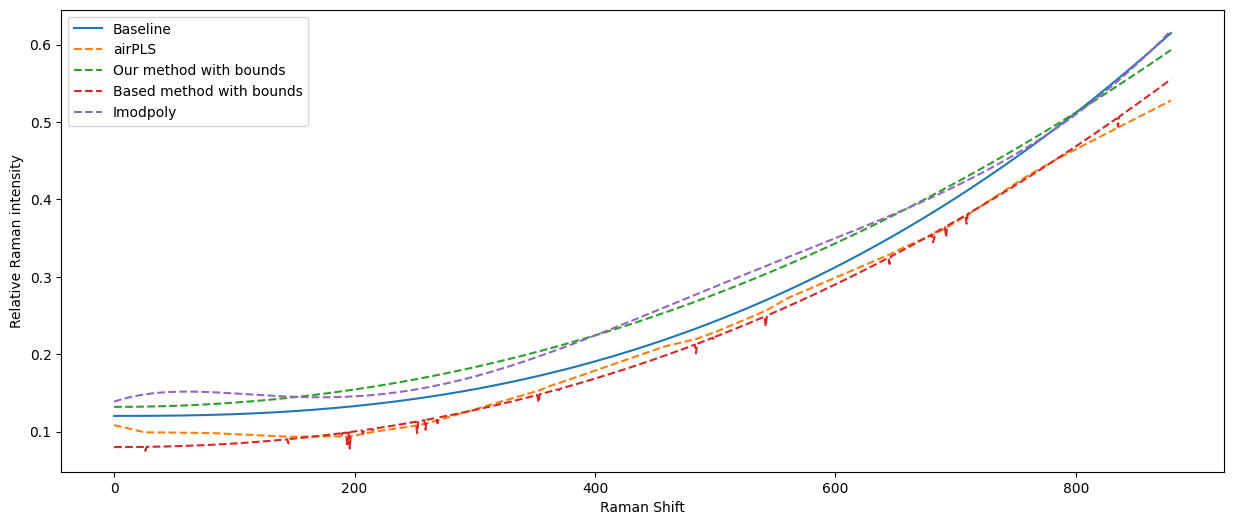

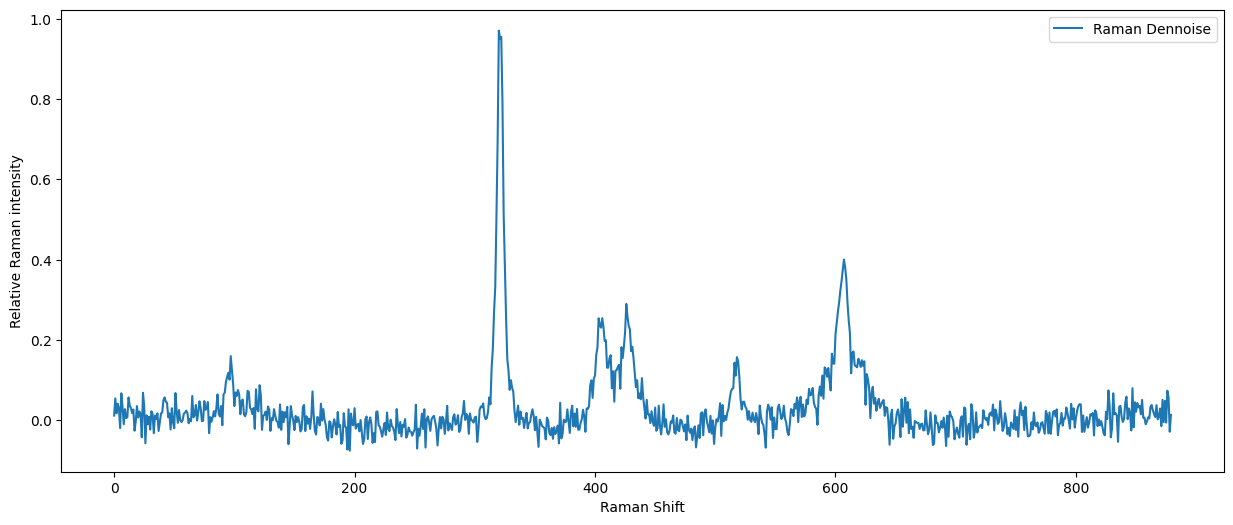

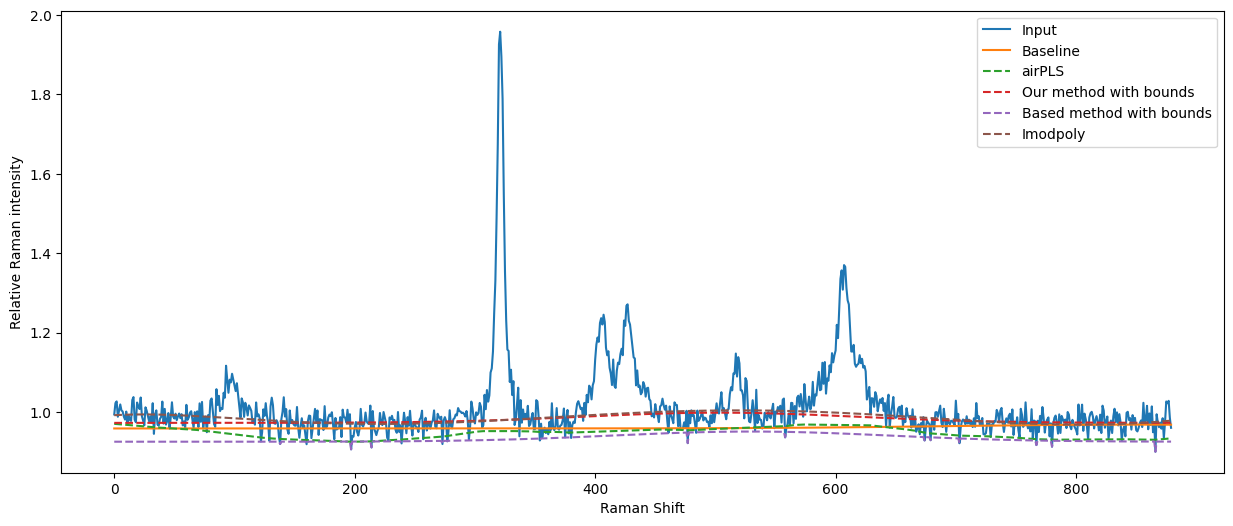

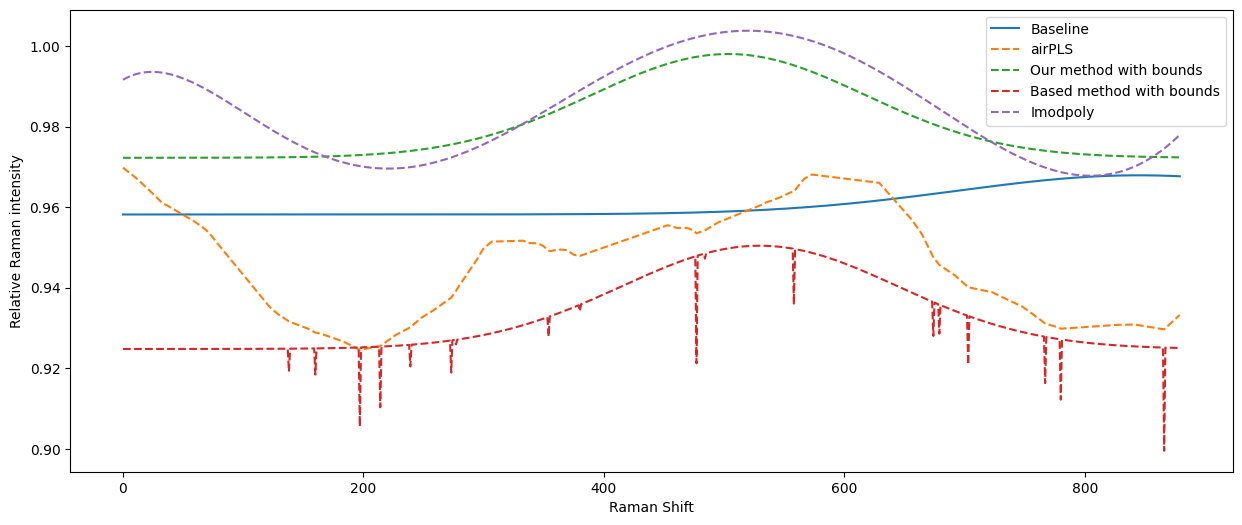

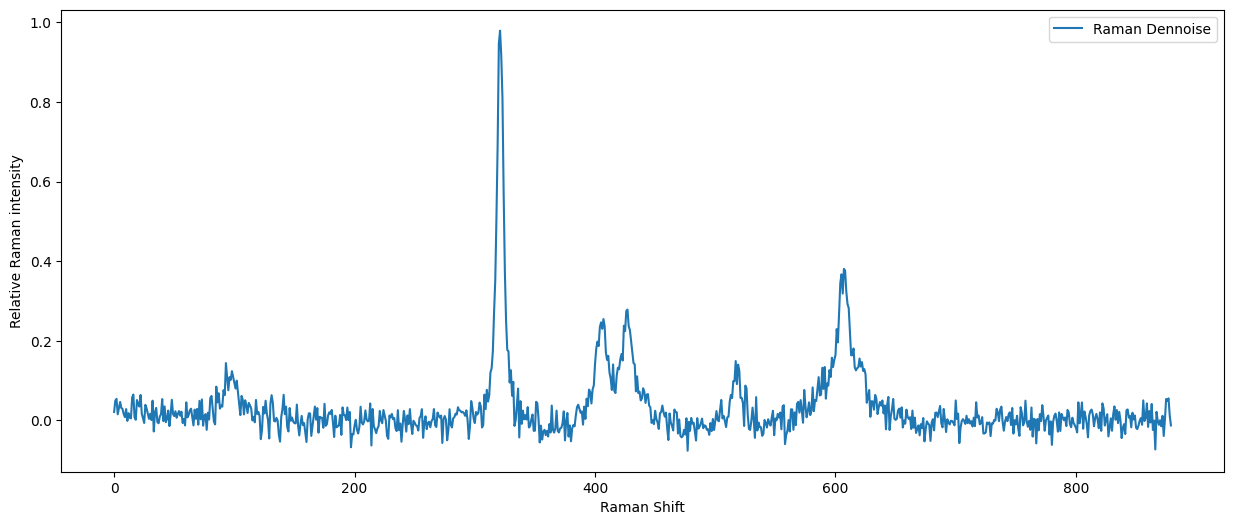

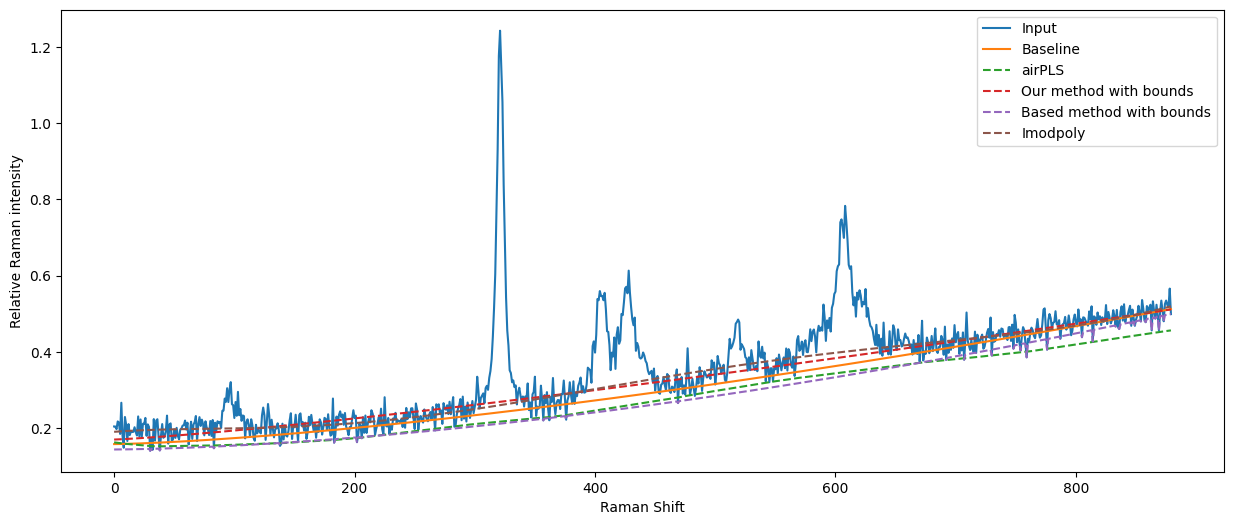

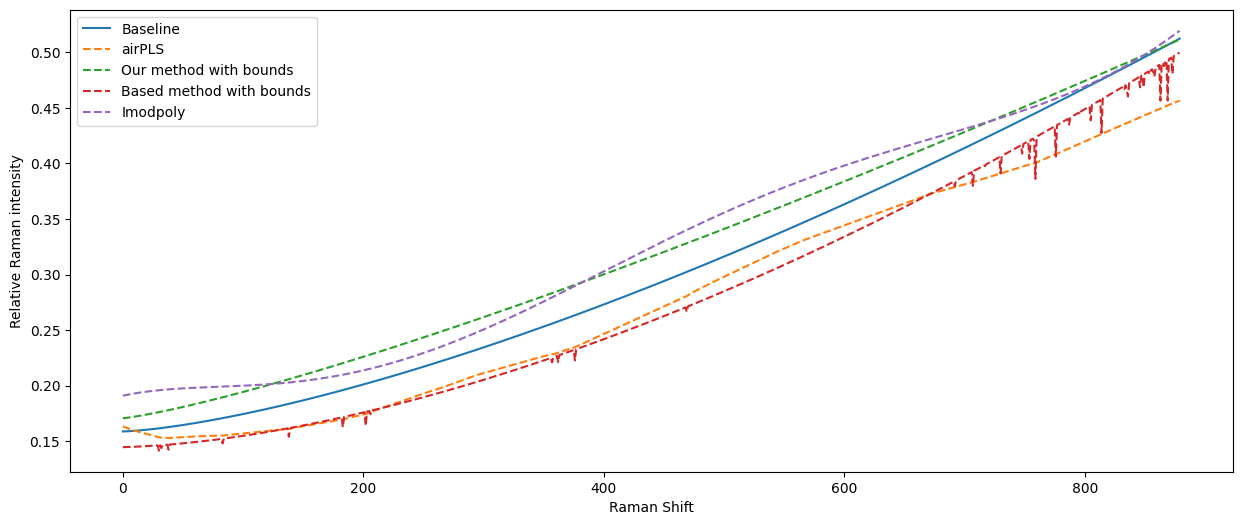

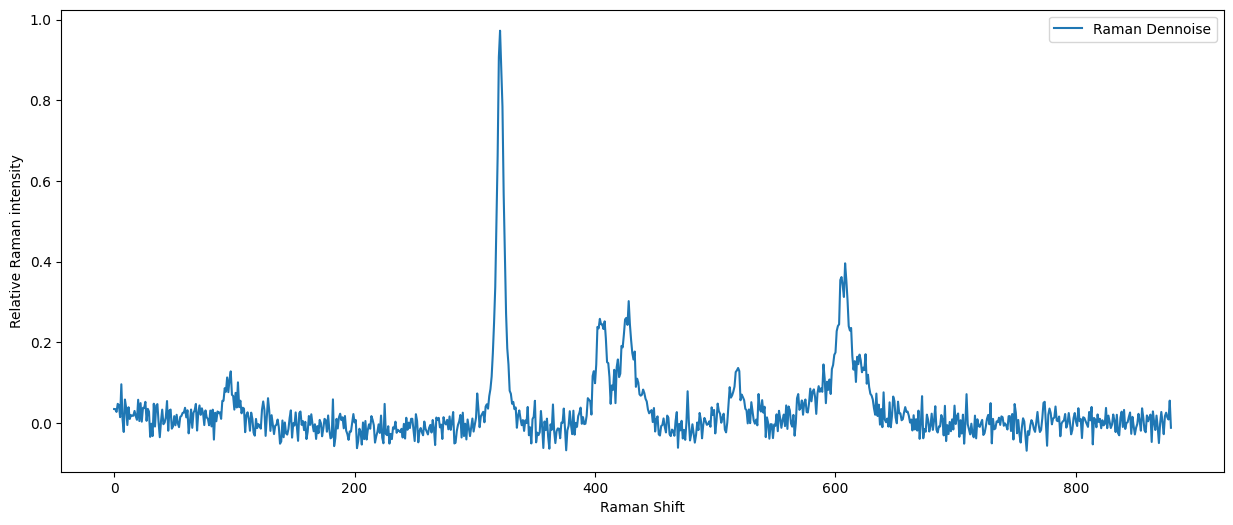

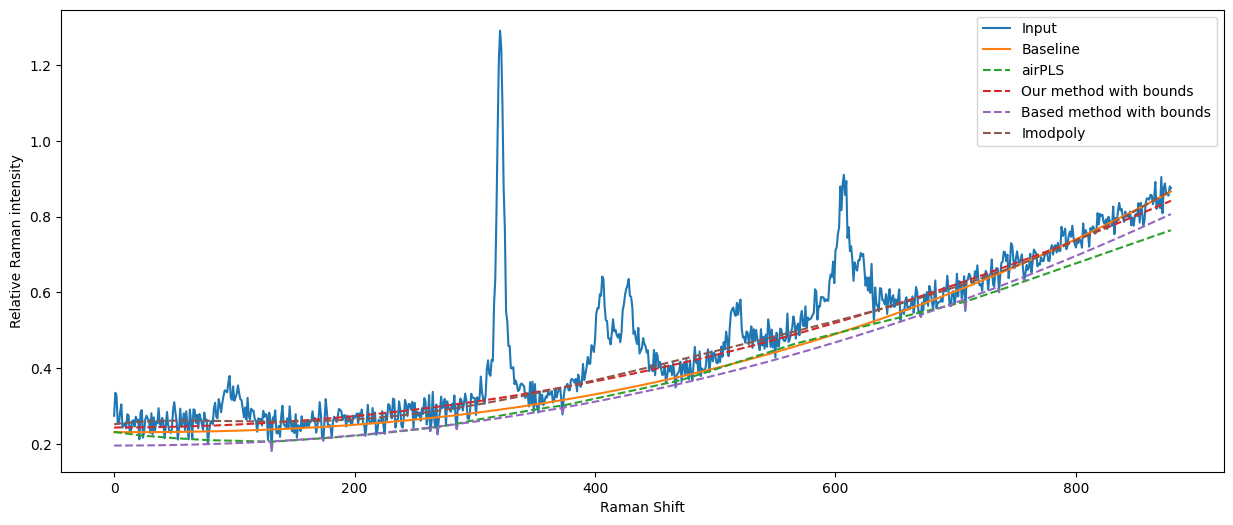

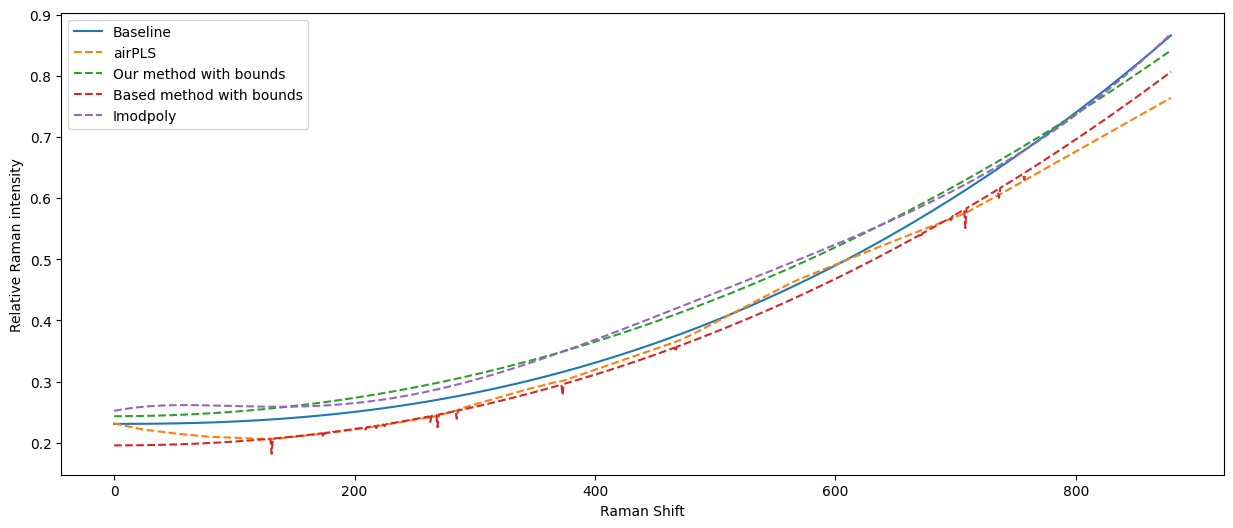

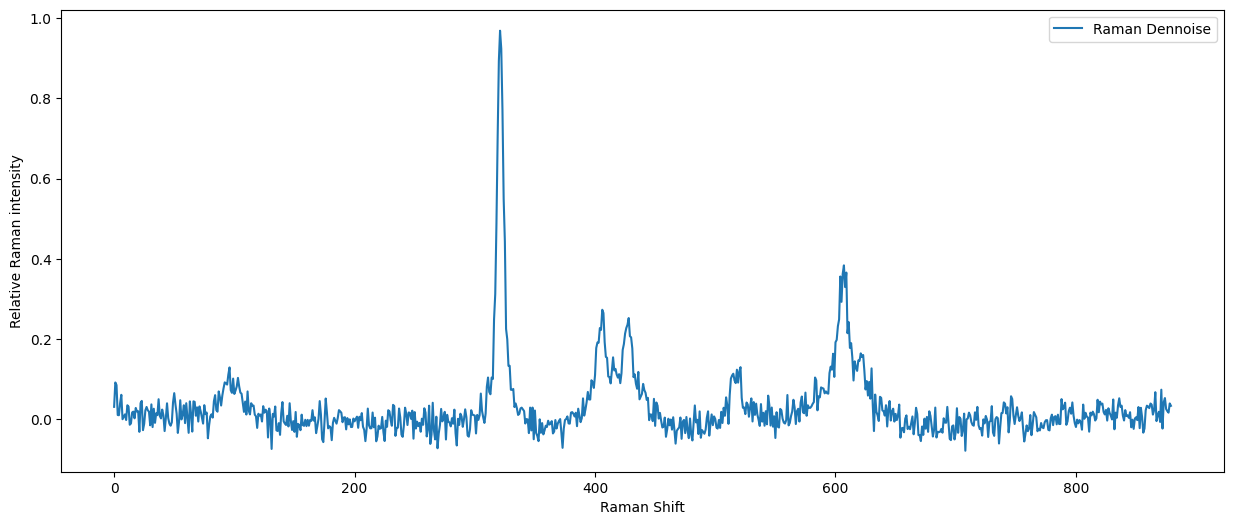

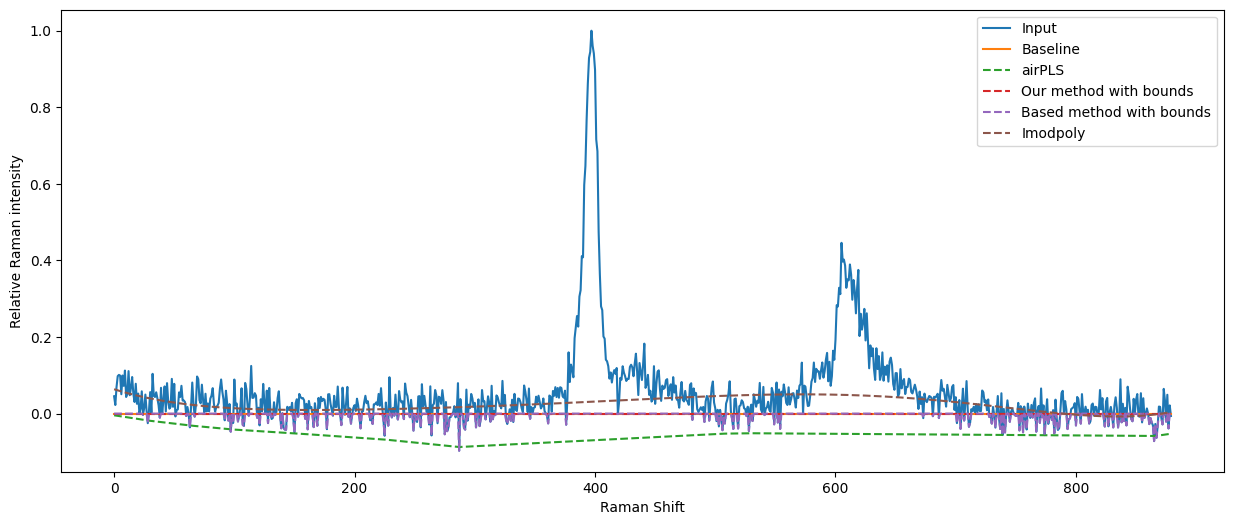

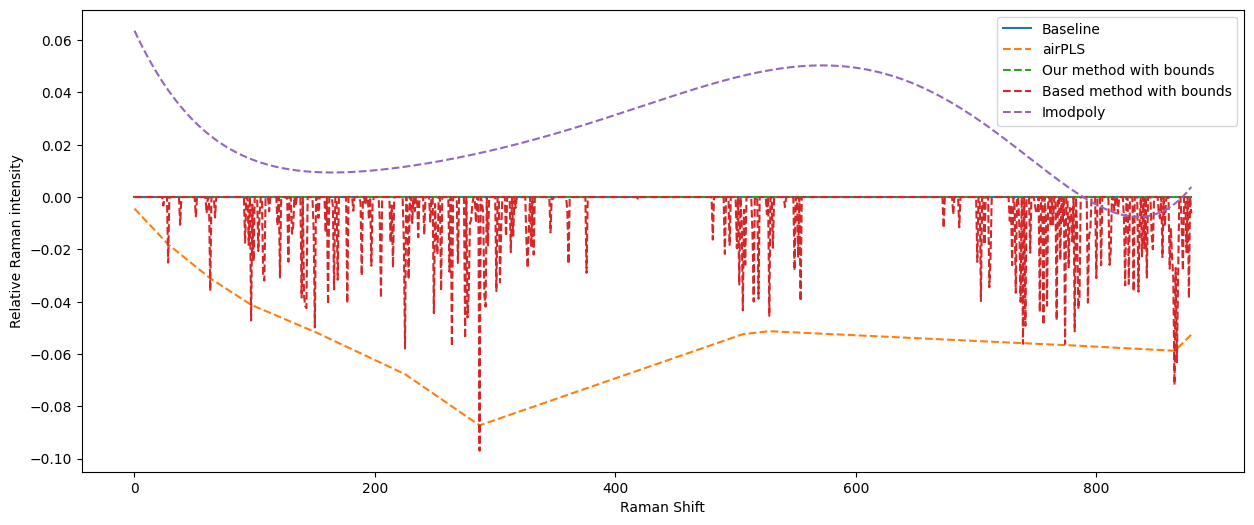

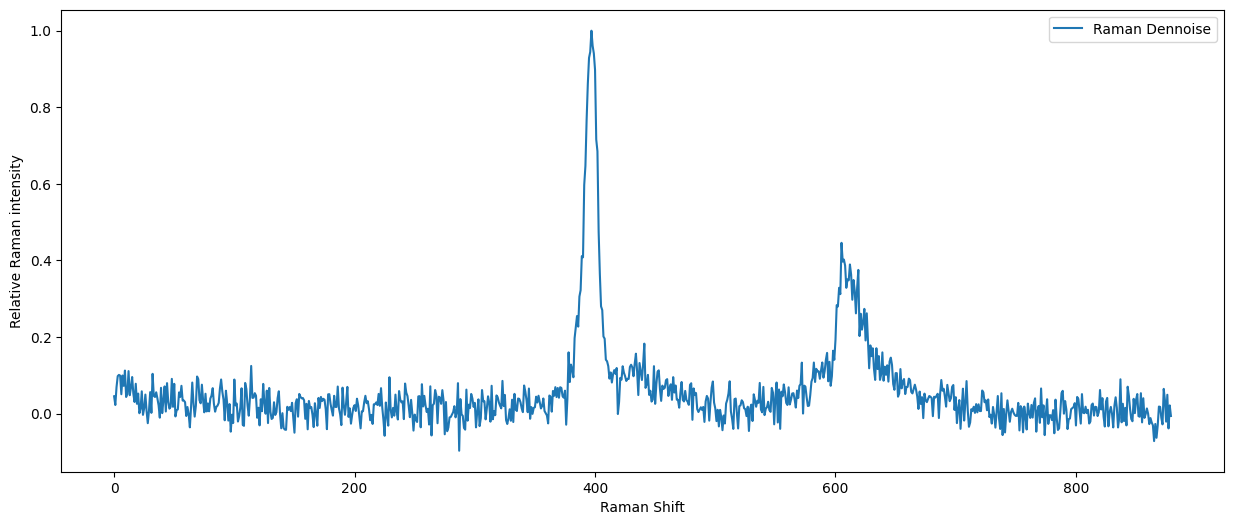

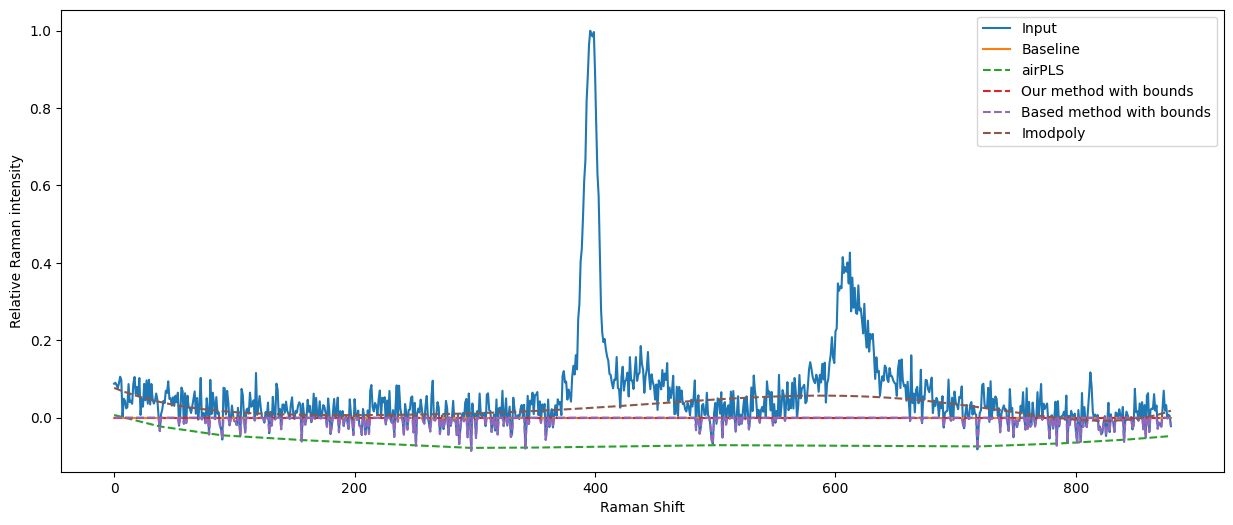

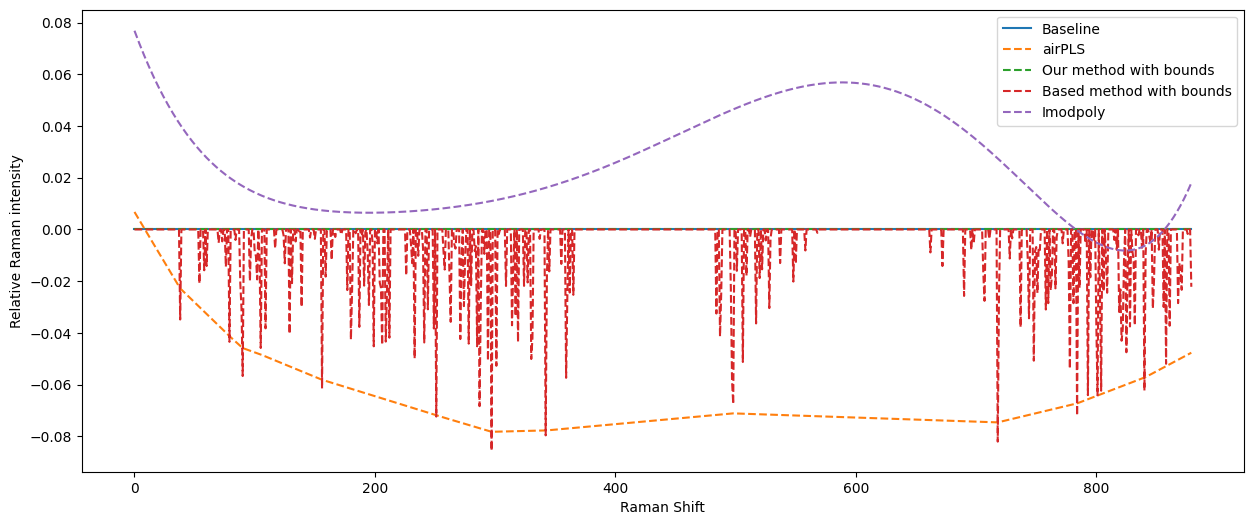

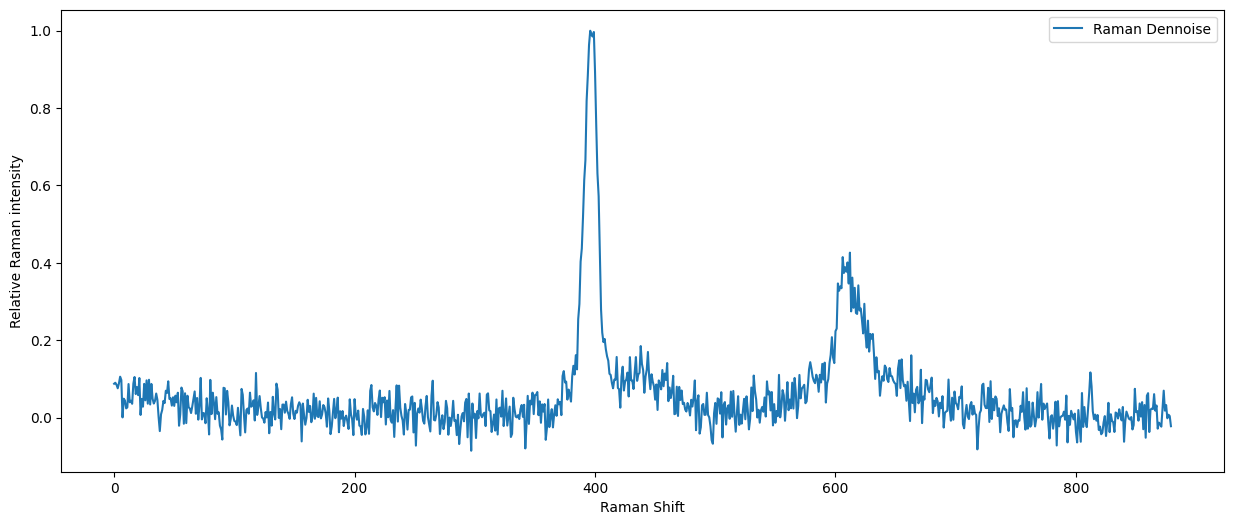

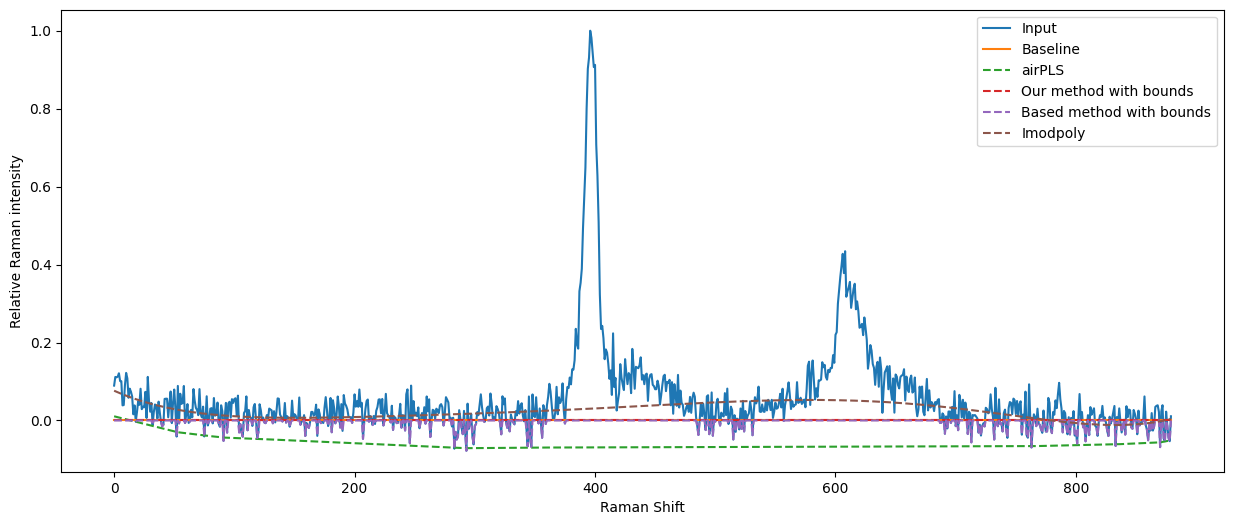

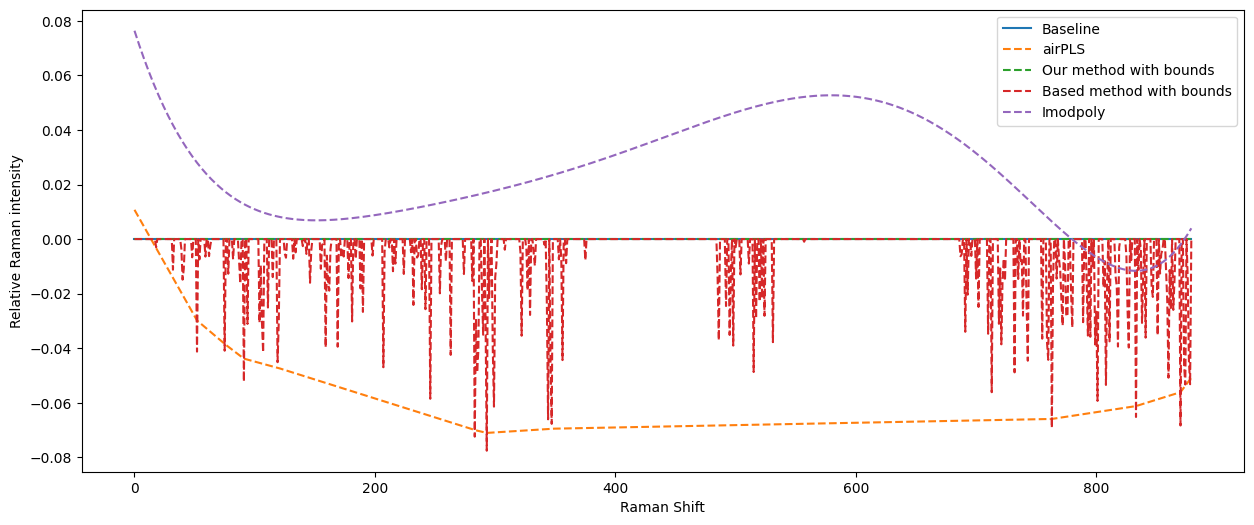

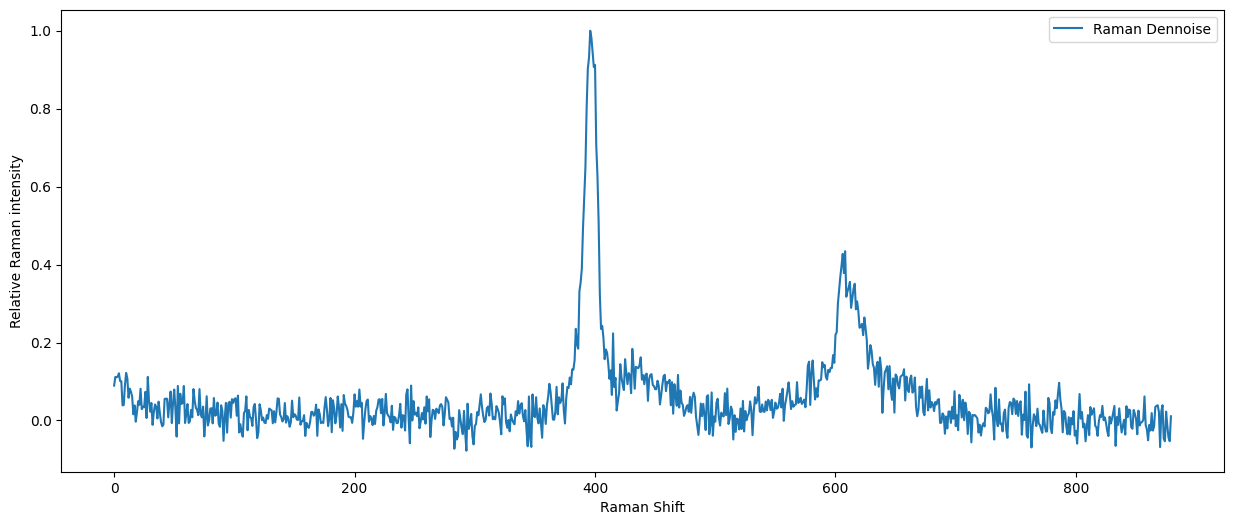

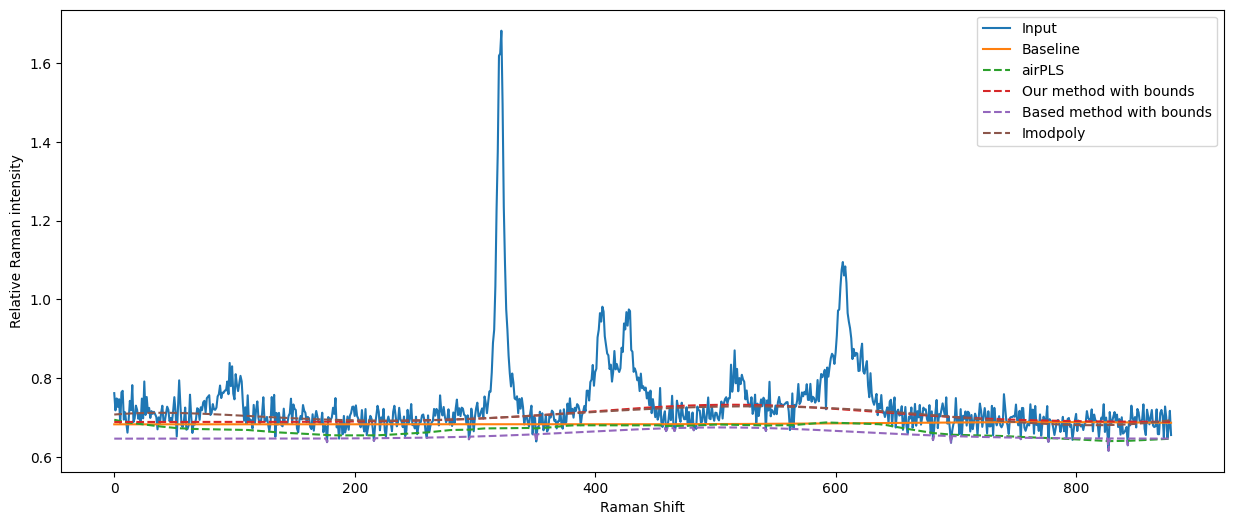

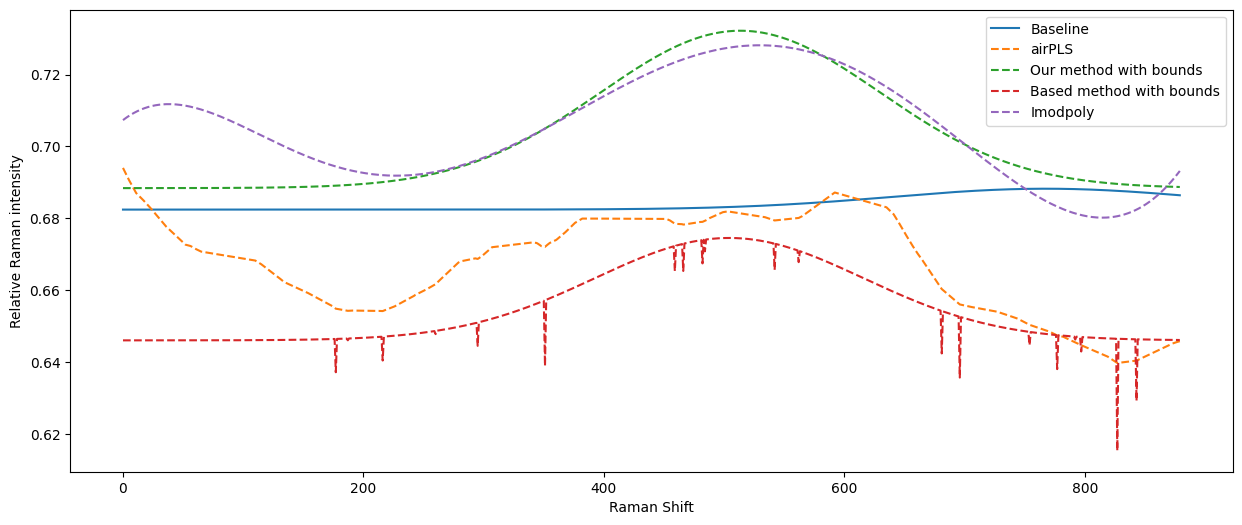

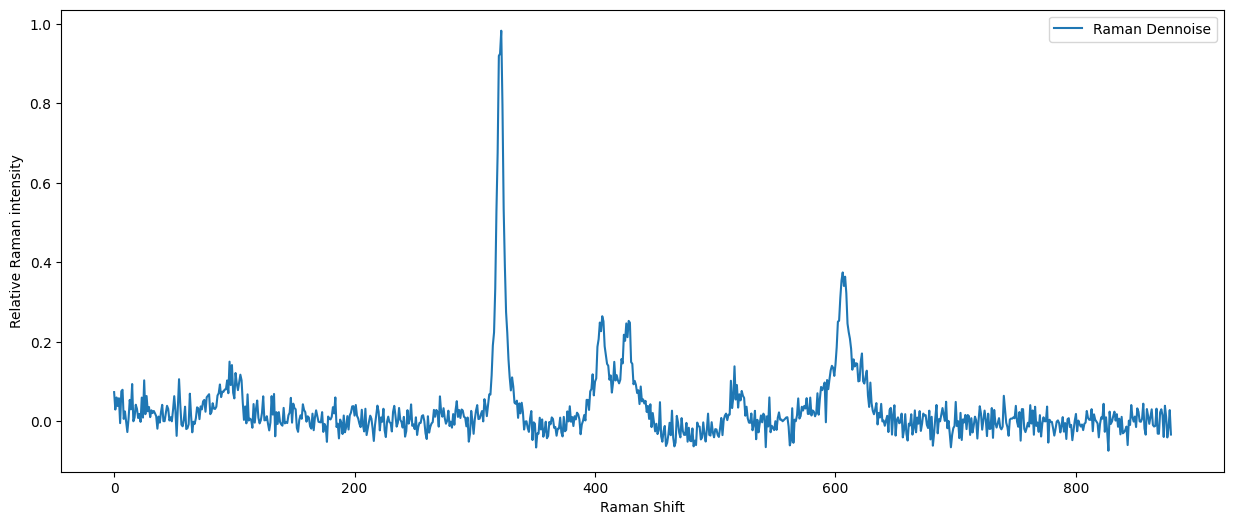

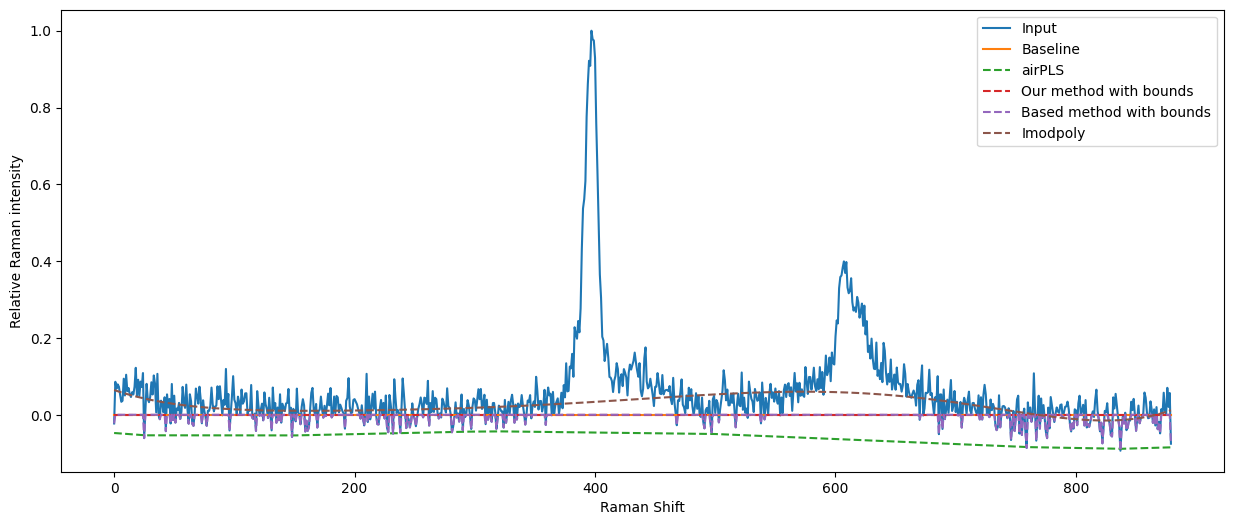

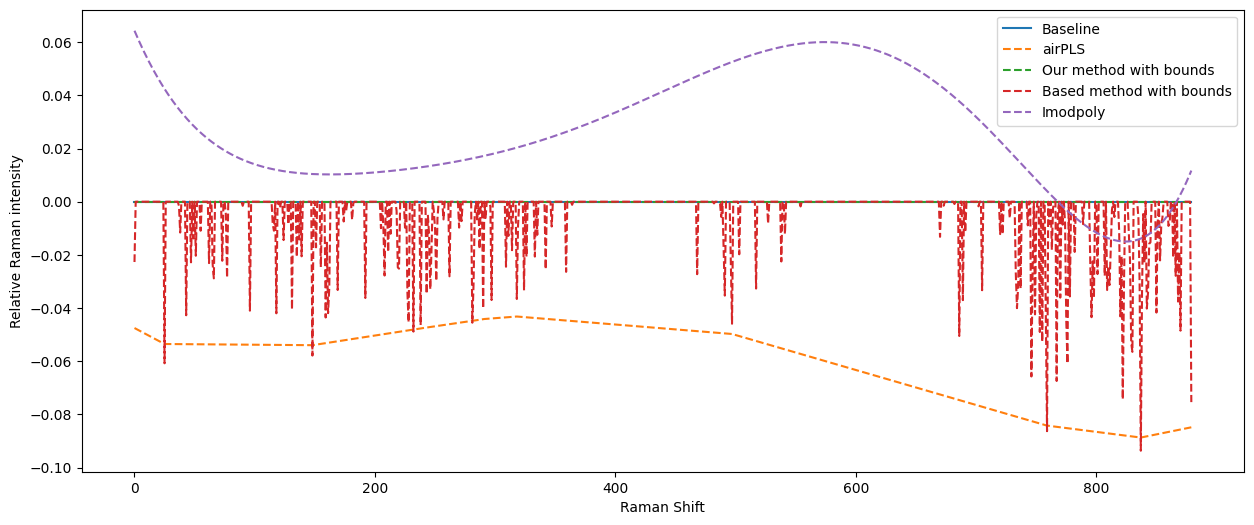

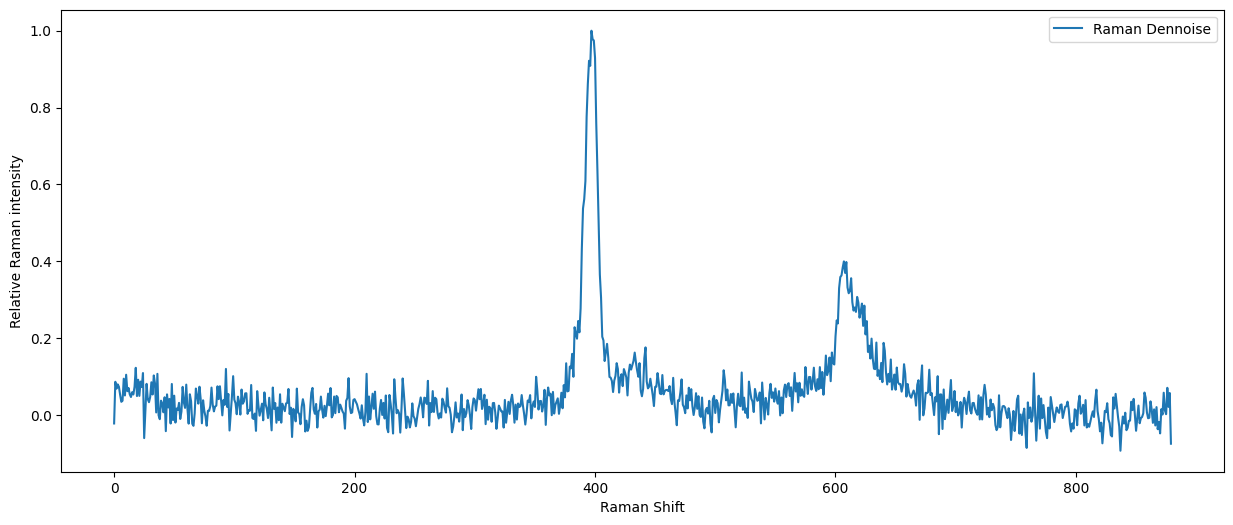

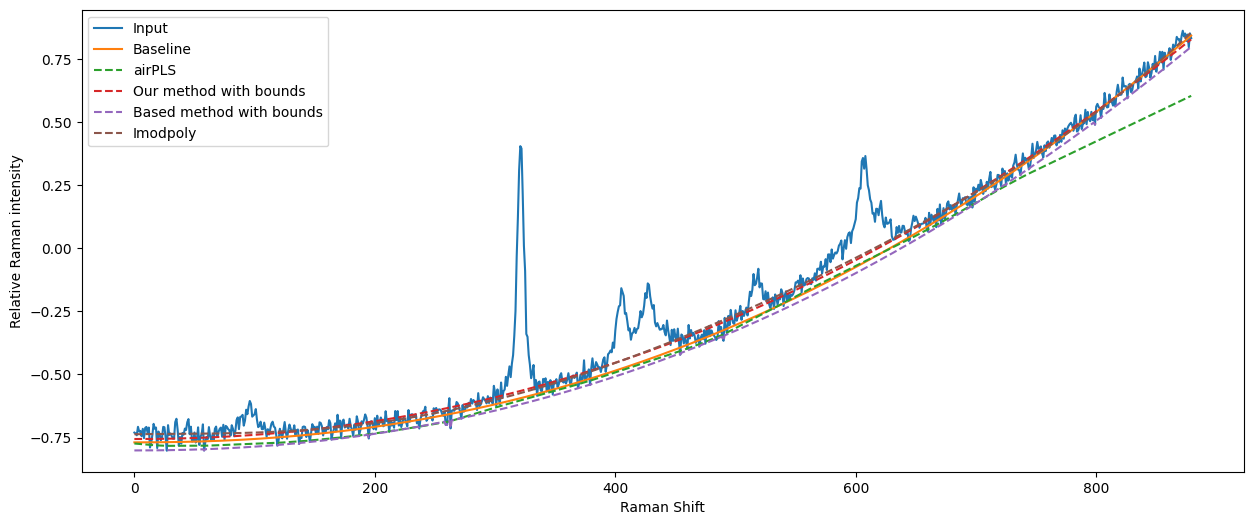

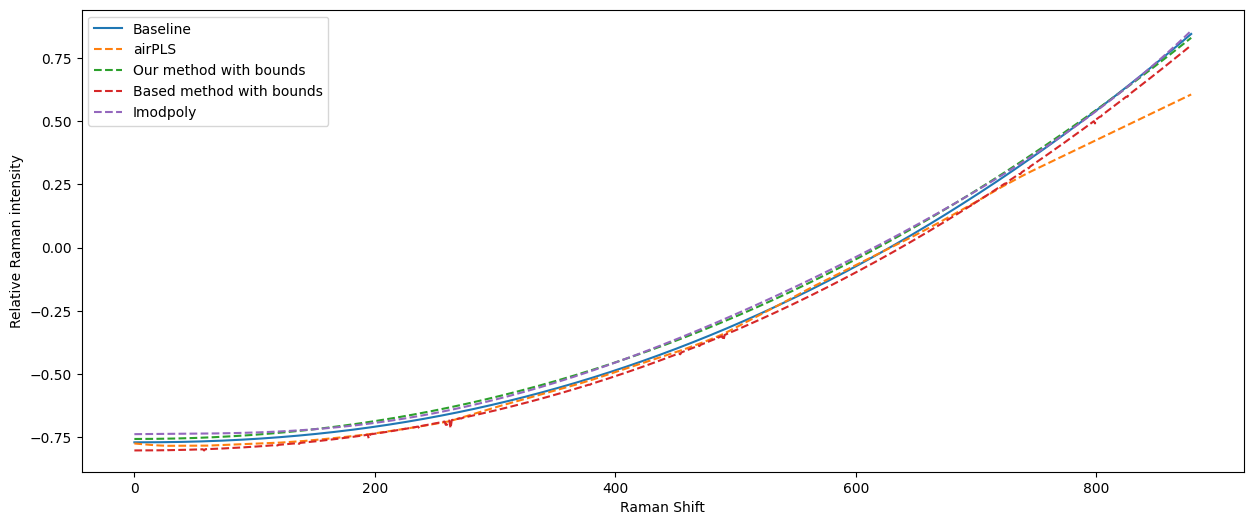

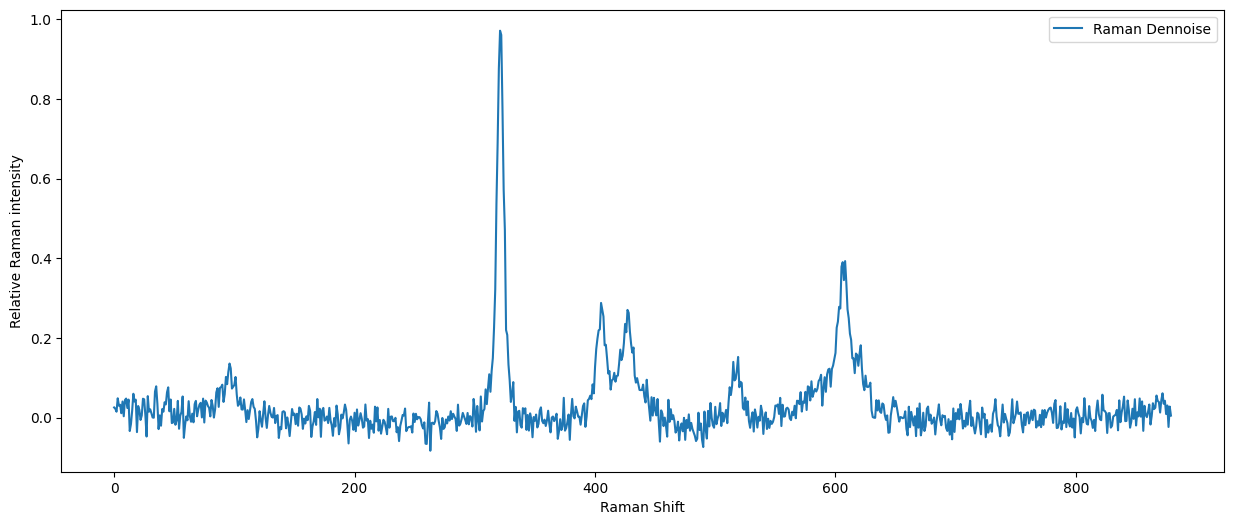

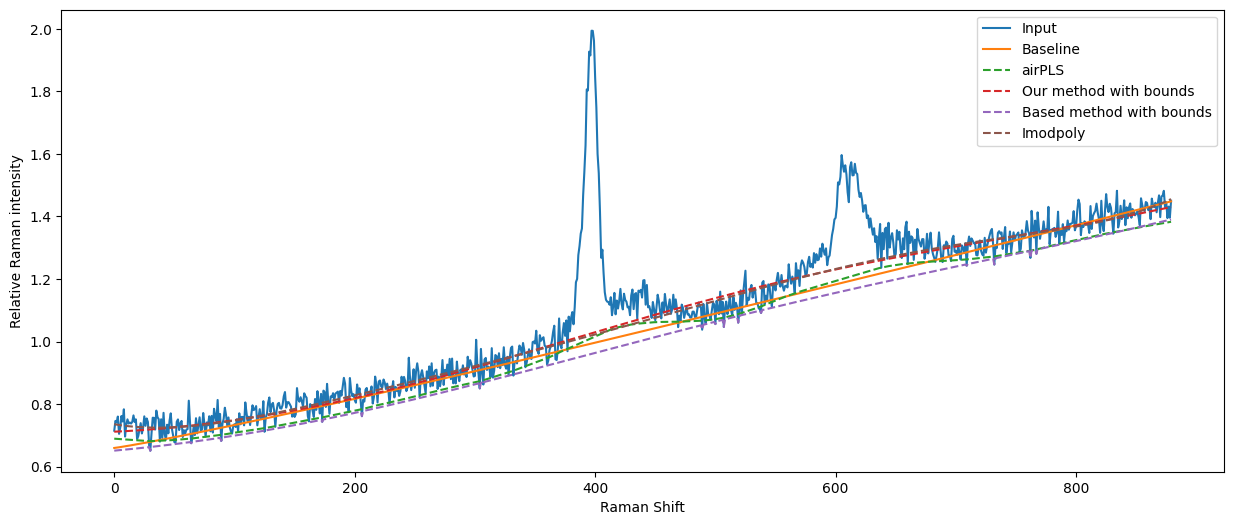

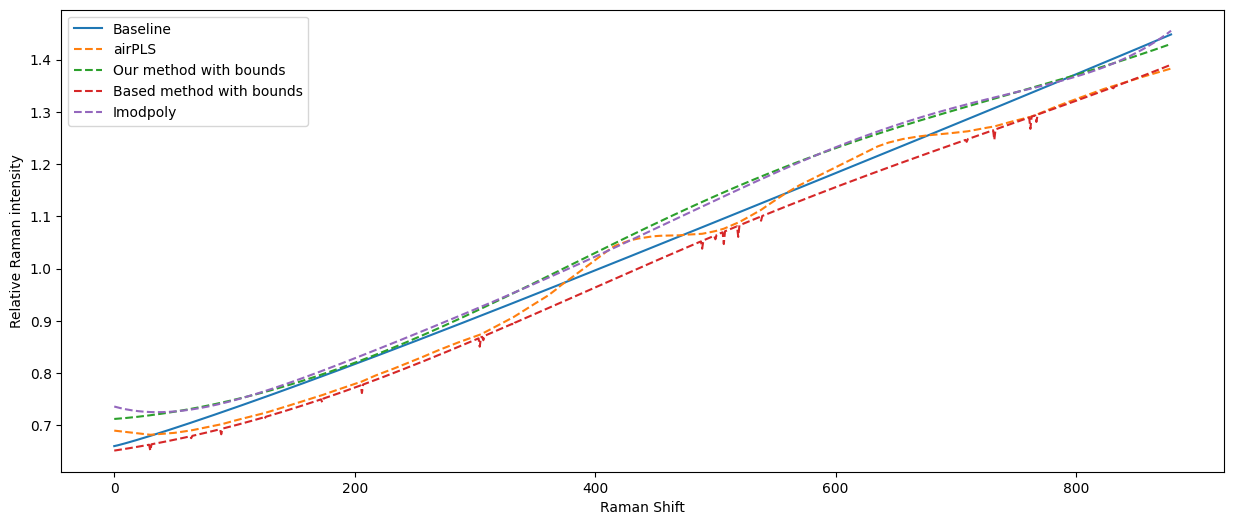

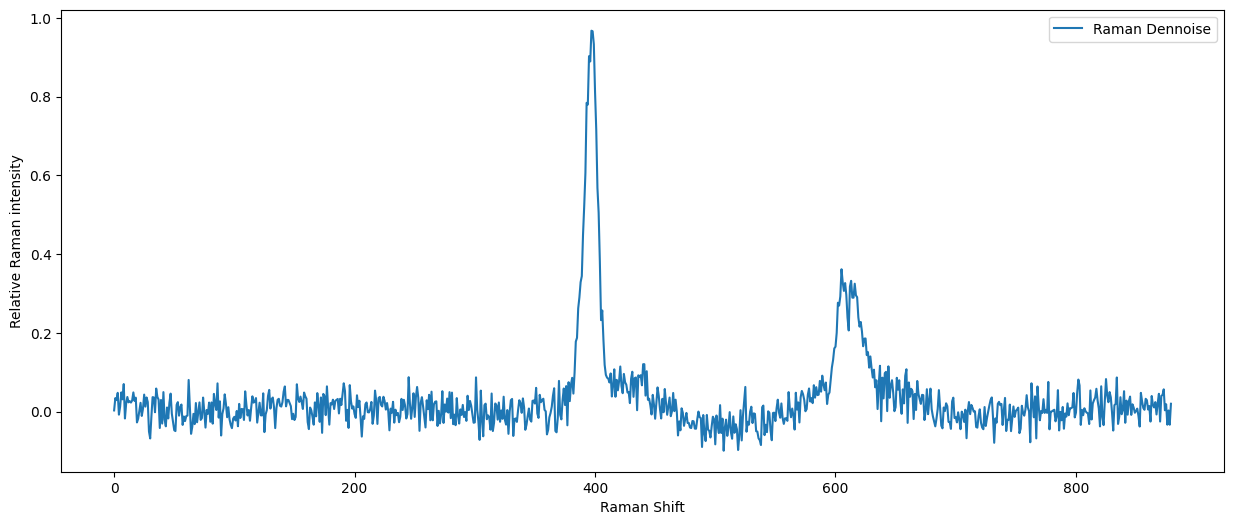

In [22]:
import matplotlib.pyplot as plt
import pybaselines
import pandas as pd

# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_test_01104.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")

# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

for i in range(0,20):
    plt.figure(figsize=(15,6))

    sample_index = i
    sample_data = x_train[sample_index]
    xx=tf.expand_dims(sample_data, axis=0)
    plt.plot(sample_data, label="Input")
    plt.plot(baseline_train[sample_index], label="Baseline")
    output=model(xx)
    B =iterative_fitting_with_bounds(sample_data,50)
    B_1 =iterative_fitting_with_bounds_no(sample_data,50)
    
    base_lines2 , _ = pybaselines.polynomial.imodpoly(data=xx[0], poly_order=6, max_iter=500)
    sample_data_1 = sample_data
    B3=airPLS(sample_data)
    plt.plot(B3,"--",label="airPLS")
    plt.plot(B, "--", label="Our method with bounds")
    plt.plot(B_1, "--", label="Based method with bounds")
    plt.plot(base_lines2, "--", label="Imodpoly")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()
    
    plt.figure(figsize=(15,6))
    plt.plot(baseline_train[sample_index], label="Baseline")
    plt.plot(B3,"--",label="airPLS")
    plt.plot(B, "--", label="Our method with bounds")
    plt.plot(B_1, "--", label="Based method with bounds")
    
    plt.plot(base_lines2, "--", label="Imodpoly")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()

    plt.figure(figsize=(15,6))
    plt.plot(sample_data - B, label="Raman Dennoise")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()

In [8]:
print(x_train.shape)
print(baseline_train.shape)
print(y_train.shape)
Input_Data = './data/dataset_noise_pure_182.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
print(Inputs.shape)
input1 = Inputs[:,0,:,-1]
print(input1.size)
input2 = Inputs[:,1,:,-1]

(15000, 880)
(15000, 880)
(15000, 2)
(15000, 2, 880, 1)
13200000


In [ ]:
import numpy as np
import tensorflow as tf
import time
from skimage.metrics import structural_similarity as ssim
import pybaselines
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Hàm tính SNR
def calculate_snr(y_s, y_hat):
    numerator = np.sum(y_s)
    denominator = np.sum((y_s - y_hat) ** 2)
    return numerator / denominator

# Hàm tính SSIM
def calculate_ssim(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_true.max() - y_true.min())

# Thiết lập số lượng mẫu trên mỗi nhóm và tổng số mẫu cần đo
group_size = 32
total_samples = 3200  # Số mẫu cần tính
num_groups = total_samples // group_size

# Biến lưu trữ tổng SNR, MSE và SSIM cho tất cả mẫu
total_snr_B = total_snr_B_1 = total_snr_base_lines2 = total_snr_B3 = 0
total_mse_B = total_mse_B_1 = total_mse_base_lines2 = total_mse_B3 = 0
total_ssim_B = total_ssim_B_1 = total_ssim_base_lines2 = total_ssim_B3 = 0

# Biến lưu trữ thời gian thực thi của mỗi phương pháp
total_time_B = total_time_B_1 = total_time_base_lines2 = total_time_B3 = 0

# Ghi lại thời gian bắt đầu tổng quát
start_time = time.time()

# Chạy qua từng nhóm mẫu và tính trung bình cho mỗi nhóm
print(f"Running total: {num_groups} batches of size {group_size}")
for group_idx in range(num_groups):
    print(f"Processing group {group_idx + 1}/{num_groups}")

    # Biến để lưu trữ SNR, MSE và SSIM cho từng nhóm
    group_snr_B = group_snr_B_1 = group_snr_base_lines2 = group_snr_B3 = 0
    group_mse_B = group_mse_B_1 = group_mse_base_lines2 = group_mse_B3 = 0
    group_ssim_B = group_ssim_B_1 = group_ssim_base_lines2 = group_ssim_B3 = 0

    for i in range(group_size):
        sample_index = group_idx * group_size + i
        sample_data = x_train[sample_index]  # Tín hiệu gốc có nhiễu
        true_data = input2[sample_index] / max(input2[sample_index])  # Chuẩn hóa tín hiệu Raman thực
        baseline = baseline_train[sample_index]

        # Tính baseline cho từng phương pháp và đo thời gian thực hiện
        start_B = time.time()
        B = iterative_fitting_with_bounds(sample_data, 100)
        total_time_B += time.time() - start_B

        start_B_1 = time.time()
        B_1 = iterative_fitting_with_bounds_no(sample_data, 100)
        total_time_B_1 += time.time() - start_B_1

        start_base_lines2 = time.time()
        base_lines2, _ = pybaselines.polynomial.imodpoly(data=tf.expand_dims(sample_data, axis=0)[0], poly_order=6, max_iter=500)
        total_time_base_lines2 += time.time() - start_base_lines2

        start_B3 = time.time()
        B3 = airPLS(sample_data)
        total_time_B3 += time.time() - start_B3
        
        plt.plot(sample_data - B, "--", label="Our method with bounds")
        plt.plot(true_data, "--", label="true data")
        plt.xlabel("Raman Shift")
        plt.ylabel("Relative Raman intensity")
        plt.legend()
        # Tính SNR cho từng phương pháp khử baseline
        group_snr_B += calculate_snr(true_data, sample_data - B)
        group_snr_B_1 += calculate_snr(true_data, sample_data - B_1)
        group_snr_base_lines2 += calculate_snr(true_data, sample_data - base_lines2)
        group_snr_B3 += calculate_snr(true_data, sample_data - B3)

        # Tính MSE cho từng phương pháp
        group_mse_B += calculate_rmse(baseline, sample_data - B)
        group_mse_B_1 += calculate_rmse(baseline, sample_data - B_1)
        group_mse_base_lines2 += calculate_rmse(baseline, sample_data - base_lines2)
        group_mse_B3 += calculate_rmse(baseline, sample_data - B3)
        
        # Tính SSIM cho từng phương pháp
        group_ssim_B += calculate_ssim(true_data, sample_data - B)
        group_ssim_B_1 += calculate_ssim(true_data, sample_data - B_1)
        group_ssim_base_lines2 += calculate_ssim(true_data, sample_data - base_lines2)
        group_ssim_B3 += calculate_ssim(true_data, sample_data - B3)

    # Cộng dồn SNR, MSE, và SSIM trung bình của mỗi nhóm vào tổng
    total_snr_B += group_snr_B / group_size
    total_snr_B_1 += group_snr_B_1 / group_size
    total_snr_base_lines2 += group_snr_base_lines2 / group_size
    total_snr_B3 += group_snr_B3 / group_size

    total_mse_B += group_mse_B / group_size
    total_mse_B_1 += group_mse_B_1 / group_size
    total_mse_base_lines2 += group_mse_base_lines2 / group_size
    total_mse_B3 += group_mse_B3 / group_size

    total_ssim_B += group_ssim_B / group_size
    total_ssim_B_1 += group_ssim_B_1 / group_size
    total_ssim_base_lines2 += group_ssim_base_lines2 / group_size
    total_ssim_B3 += group_ssim_B3 / group_size

    # In ra các chỉ số của nhóm hiện tại
    print(f"Group {group_idx + 1} - Average SNR:")
    print(f"Our method with bounds: {group_snr_B / group_size:.4f}, Based method with bounds: {group_snr_B_1 / group_size:.4f}, Imodpoly: {group_snr_base_lines2 / group_size:.4f}, airPLS: {group_snr_B3 / group_size:.4f}")
    print(f"Group {group_idx + 1} - Average MSE:")
    print(f"Our method with bounds: {group_mse_B / group_size:.4f}, Based method with bounds: {group_mse_B_1 / group_size:.4f}, Imodpoly: {group_mse_base_lines2 / group_size:.4f}, airPLS: {group_mse_B3 / group_size:.4f}")
    print(f"Group {group_idx + 1} - Average SSIM:")
    print(f"Our method with bounds: {group_ssim_B / group_size:.4f}, Based method with bounds: {group_ssim_B_1 / group_size:.4f}, Imodpoly: {group_ssim_base_lines2 / group_size:.4f}, airPLS: {group_ssim_B3 / group_size:.4f}")
    print("-" * 50)

# Ghi lại thời gian tổng thể kết thúc
end_time = time.time()
execution_time = end_time - start_time

# Tính SNR, MSE và SSIM trung bình cho tất cả các nhóm
average_snr_B = total_snr_B / num_groups
average_snr_B_1 = total_snr_B_1 / num_groups
average_snr_base_lines2 = total_snr_base_lines2 / num_groups
average_snr_B3 = total_snr_B3 / num_groups

average_mse_B = total_mse_B / num_groups
average_mse_B_1 = total_mse_B_1 / num_groups
average_mse_base_lines2 = total_mse_base_lines2 / num_groups
average_mse_B3 = total_mse_B3 / num_groups

average_ssim_B = total_ssim_B / num_groups
average_ssim_B_1 = total_ssim_B_1 / num_groups
average_ssim_base_lines2 = total_ssim_base_lines2 / num_groups
average_ssim_B3 = total_ssim_B3 / num_groups

# Tính thời gian thực thi trung bình của mỗi phương pháp
average_time_B = total_time_B / total_samples
average_time_B_1 = total_time_B_1 / total_samples
average_time_base_lines2 = total_time_base_lines2 / total_samples
average_time_B3 = total_time_B3 / total_samples

# In ra các kết quả tổng kết
print("\nOverall Average SNR:")
print(f"Our method with bounds: {average_snr_B:.4f}")
print(f"Based method with bounds: {average_snr_B_1:.4f}")
print(f"Imodpoly: {average_snr_base_lines2:.4f}")
print(f"airPLS: {average_snr_B3:.4f}")

print("\nOverall Average MSE:")
print(f"Our method with bounds: {average_mse_B:.4f}")
print(f"Based method with bounds: {average_mse_B_1:.4f}")
print(f"Imodpoly: {average_mse_base_lines2:.4f}")
print(f"airPLS: {average_mse_B3:.4f}")

print("\nOverall Average SSIM:")
print(f"Our method with bounds: {average_ssim_B:.4f}")
print(f"Based method with bounds: {average_ssim_B_1:.4f}")
print(f"Imodpoly: {average_ssim_base_lines2:.4f}")
print(f"airPLS: {average_ssim_B3:.4f}")

print("\nAverage Execution Time per Method:")
print(f"Our method with bounds: {average_time_B:.6f} seconds")
print(f"Based method with bounds: {average_time_B_1:.6f} seconds")
print(f"Imodpoly: {average_time_base_lines2:.6f} seconds")
print(f"airPLS: {average_time_B3:.6f} seconds")

print("\nTotal Execution Time:", execution_time, "seconds")


Running total: 100 batches of size 32
Processing group 1/100
